# Google Trends Interest Analysis — FX Market Search Attention

## The Question We're Trying to Answer

Does what people search for on Google carry a measurable signal about where exchange rates are headed?

This question is less frivolous than it sounds. When a central bank makes an unexpected announcement, when inflation data shocks the market, or when geopolitical tension erupts, search volume on Google typically spikes *at the same time* or *just before* the price reaction — because retail participants, news outlets, and even some institutional desks check search trends as a real-time sentiment gauge.

The academic case for Google Trends in finance was established by Da, Engelberg & Gao (2011) who showed search attention predicts short-term retail attention and stock returns, and has since been extended to FX by several papers. The methodological problem — documented by Ketterer (2014) and Zhu et al. (2022) — is that **Google Trends values are not deterministic**: the same query on the same day, run twice, can return different numbers because Google draws a random sample of search data each time. This is the single biggest threat to reproducibility in the GT literature, and the first thing this notebook measures directly.

---

## Our Specific Contribution

Most GT-FX papers (a) use a single pull per keyword, (b) pick geo=US without justification, (c) use raw (unscaled) values, and (d) run in-sample tests. We address all four:

1. **Cross-extraction consistency auditing** — measure how much GT values change between two independent extraction windows (a lower bound on true multi-pull reliability, which requires 10–30 repeated downloads)
2. **Geo aggregation** — compare single-geo vs median-across-all-geos (reduces geo noise)
3. **Heuristic anchor rescaling** — simplified G-TAB-inspired approach (Zhu et al. 2022) to stabilise keyword scales across time (note: not a full G-TAB implementation)
4. **Strict out-of-sample evaluation** — walk-forward expanding window; benchmark (RW) never re-fitted
5. **Data-snooping controls** — White's Reality Check + Hansen's SPA after testing 20 pipeline×model combinations

---

## Notebook Flow

| # | Section | Key Question | Output |
|---|---|---|---|
| 0 | **Config** | What parameters govern this run? | — |
| 1 | **Imports + helpers** | — | — |
| 2 | **GT data loading** | How much data did we collect? | Merged DataFrame |
| 3 | **Cross-extraction consistency** | Which keywords are stable across extraction windows? | `gt_consistency_table.csv` |
| 4 | **FX panel** | What is our forecast target? | Weekly log returns / RV |
| 5 | **Feature pipelines** | How do we turn raw GT into features? | 4 pipeline variants |
| 6 | **EDA** | What do the trends look like against FX? | Time series + correlation plots |
| 7 | **Walk-forward OOS** | Do GT features beat Random Walk + AR baselines? | Performance table |
| 8 | **Raw GT hurts test** | Does preprocessing rescue a failing signal? | `gt_helps_table.csv` |
| 9 | **Geo/gprop robustness** | Is any result geo-specific or gprop-specific? | Delta-skill heatmap |
| 10 | **DM + HLN** | Is the best model statistically significantly better? | DM/HLN table |
| 11 | **RC + SPA** | Does any result survive snooping correction? | `*_pvalue_*.txt` |
| 12 | **Stability 2022** | Did GT-FX relationships change after Google's 2022 methodology update? | Correlation change matrix |
| 13 | **Silver export** | Is the processed data ready for the Sentiment Agent? | `macro_GTRENDS_*.csv` |
| 14 | **rv_14 experiment** | Does GT predict volatility better than returns? | rv_14 leaderboard |
| 15 | **Final results** | Consolidated leaderboard + statistical tests | Summary tables |

*Data: Google Trends merged CSV + Real MT5 GBPUSD H1 CSV*

In [ ]:
# ══════════════════════════════════════════════════════════════════════════
# MASTER CONFIG — change here; everything below reads from these variables
# ══════════════════════════════════════════════════════════════════════════

import os
from pathlib import Path

# ── Environment detection ─────────────────────────────────────────────────
IN_COLAB = "COLAB_GPU" in os.environ or "COLAB_RELEASE_TAG" in os.environ

if IN_COLAB:
    from google.colab import drive
    drive.mount("/content/drive")
    # ── Colab users: place data files in this Google Drive folder ─────
    #    MyDrive/FX-AlphaLab-data/
    #      ├── google_trends_FULL_MERGED.csv
    #      ├── mt5_GBPUSD_H1_20260210.csv
    #      └── (optional) google_trends_calibrated.csv
    DRIVE_DATA = Path("/content/drive/MyDrive/FX-AlphaLab-data")
    BASE_PATH  = Path("/content/FX-AlphaLab")
else:
    # ── Local: resolve repo root from notebooks/ or repo root ─────────
    BASE_PATH = Path(".").resolve()
    if not (BASE_PATH / "src").exists():
        BASE_PATH = BASE_PATH.parent

# ── Data sources (relative paths — portable across machines) ──────────────
# GT merged CSV:  data/raw/attention/google_trends/google_trends_FULL_MERGED.csv
# MT5 FX data:    data/raw/mt5/mt5_{PAIR}_{TIMEFRAME}_{DATE}.csv
#
# If files are not found at the default relative paths, the notebook will
# check DRIVE_DATA (Colab) or print instructions telling you where to place them.

GT_RAW_DIR    = BASE_PATH / "data" / "raw" / "attention" / "google_trends"
PROCESSED_DIR = BASE_PATH / "data" / "processed" / "macro"
OUTPUTS_DIR   = BASE_PATH / "outputs"

# Primary GT merged CSV — try repo first, then Colab Drive
_gt_repo  = GT_RAW_DIR / "google_trends_FULL_MERGED.csv"
_gt_drive = DRIVE_DATA / "google_trends_FULL_MERGED.csv" if IN_COLAB else _gt_repo
GT_MERGED_CSV = _gt_repo if _gt_repo.exists() else _gt_drive

# Optional calibrated CSV
CALIB_CSV = PROCESSED_DIR / "google_trends_calibrated.csv"

# ── MT5 FX data ──────────────────────────────────────────────────────────
PAIR      = "GBPUSD"
TIMEFRAME = "H1"

_mt5_repo  = BASE_PATH / "data" / "raw" / "mt5"
_mt5_drive = DRIVE_DATA if IN_COLAB else _mt5_repo
MT5_DIR    = _mt5_repo if _mt5_repo.exists() else _mt5_drive

# ── Google Trends filters ─────────────────────────────────────────────────
GEO_LIST = ["GLOBAL", "GB", "US"]
GPROP    = "web"

# ── Forecast target ───────────────────────────────────────────────────────
TARGET = "ret_1"    # "ret_1" (1-week log return) or "rv_14" (volatility)

# ── Model settings ────────────────────────────────────────────────────────
N_LAGS      = [1, 2, 4]
MIN_TRAIN   = 52
RIDGE_ALPHA = 1.0

# ── Create output dirs ───────────────────────────────────────────────────
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
OUTPUTS_DIR.mkdir(parents=True, exist_ok=True)

# ── Validation ────────────────────────────────────────────────────────────
_missing = []
if not GT_MERGED_CSV.exists():
    _missing.append(f"GT merged CSV not found. Place it at:\n  {_gt_repo}")
if not list(MT5_DIR.glob(f"mt5_{PAIR}_{TIMEFRAME}_*.csv")):
    _missing.append(f"MT5 {PAIR} {TIMEFRAME} CSV not found. Place it at:\n  {_mt5_repo}/")
if _missing:
    print("⚠️  MISSING DATA FILES:")
    for m in _missing:
        print(f"  • {m}")
    print()

print("Configuration")
print(f"  Environment : {'Google Colab' if IN_COLAB else 'Local'}")
print(f"  Pair        : {PAIR}  ({TIMEFRAME})")
print(f"  MT5 dir     : {MT5_DIR}")
print(f"  MT5 found   : {bool(list(MT5_DIR.glob(f'mt5_{PAIR}_{TIMEFRAME}_*.csv')))}")
print(f"  GT filter   : geos={GEO_LIST}, gprop={GPROP}")
print(f"  Target      : {TARGET}")
print(f"  Lags        : {N_LAGS},  min_train={MIN_TRAIN}")
print(f"  Base path   : {BASE_PATH}")
print(f"  GT CSV      : {GT_MERGED_CSV.exists()}")
print(f"  Calib CSV   : {CALIB_CSV.exists()} (optional)")

Configuration
  Pair      : GBPUSD  (GBPUSDm, H1)
  GT filter : geos=['GLOBAL', 'GB', 'US'], gprop=web
  Target    : ret_1
  Lags      : [1, 2, 4],  min_train=52
  Base path : C:\Users\MSI GF63 I7\repos\FX-AlphaLab
  GT CSV    : True
  Calib CSV : False (optional)


### What the Configuration Controls

Every downstream result — reliability scores, feature matrices, model comparisons, significance tests — flows from the constants set here. Understanding why each was chosen helps interpret results correctly.

**Data parameters:**
- `GT_MERGED_CSV` — the aggregated pull from all raw source files, produced by the Google Trends collector. Contains every `(keyword, geo, gprop, date)` with its last-seen interest value and the source file it came from.
- `GT_RAW_DIR` — the individual per-query CSV files. These are what allows us to measure cross-window consistency: two files for the same keyword queried at different clock times on the same day give us two independent measurements.
- `PAIR = "GBPUSD"` / `PAIR_SYM = "GBPUSDm"` — GBP is chosen as an interesting test case for search-attention effects because UK events (BoE decisions, inflation prints, budget statements) generate disproportionate search spikes relative to their actual economic size. Re-run with `EURUSD` or `USDJPY` for comparison.

**Forecast settings:**
- `TARGET = "ret_1"` (1-week log return) — the primary prediction target. Switch to `"rv_14"` (4-week rolling std) to test whether search attention predicts volatility rather than direction, which is a meaningfully different hypothesis.
- `N_LAGS = [1, 2, 4]` — features are lagged 1, 2, and 4 weeks. This is deliberately conservative: we do not use the contemporaneous GT value (lag=0) because in a genuine trading setting, the GT week ending Sunday is only fully available on Monday, not usable to trade the same week. Lag=4 tests whether the effect persists beyond one month.
- `MIN_TRAIN = 52` — one full year before the first OOS prediction. Ensures Ridge sees at least one full macro cycle before making forecasts.
- `RIDGE_ALPHA = 1.0` — L2 regularisation. With 30+ keywords × 3 lags = 90+ features and only 200-odd observations, regularisation is not optional. It prevents the model from fitting training-set noise.

**Reliability parameter:**
- `STABILITY_THRESHOLD = 0.60` — a keyword is "usable" if `1/(1+avg_pull_std) ≥ 0.60`, equivalently if the average cross-window std ≤ 67 points (on a 0–100 scale). This is a pragmatic threshold: keywords below it have enough sampling noise that their series could be dominated by random variation rather than genuine search patterns.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from pathlib import Path
from scipy import stats
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")
pd.set_option("display.max_columns", None)
pd.set_option("display.precision", 4)

FIGSIZE_WIDE   = (16, 5)
FIGSIZE_TALL   = (16, 12)
FIGSIZE_SQUARE = (14, 10)

# ── Keyword taxonomy ──────────────────────────────────────────────────────
KEYWORD_CATEGORIES = {
    "FX Pairs"       : ["EURUSD","GBPUSD","USDJPY","euro dollar","pound dollar",
                         "Japanese yen","GBP exchange rate","USDCHF","Swiss franc"],
    "Central Banks"  : ["ECB","European Central Bank","Christine Lagarde",
                         "Federal Reserve","FOMC",
                         "Bank of England","BoE",
                         "Bank of Japan","BOJ"],
    "Macro Indicators": ["CPI","inflation","eurozone inflation","PMI","bond yields",
                          "rate hike","rate cut","recession","UK inflation"],
    "Risk Sentiment" : ["VIX","volatility","safe haven","market crash",
                         "DXY","dollar index","forex"],
}
KW_TO_CAT = {kw:cat for cat,kws in KEYWORD_CATEGORIES.items() for kw in kws}
CATEGORY_COLORS = {
    "FX Pairs"       : "#3498db",
    "Central Banks"  : "#e74c3c",
    "Macro Indicators": "#2ecc71",
    "Risk Sentiment" : "#f39c12",
}
GEO_COLORS = {"GLOBAL":"#2c3e50","US":"#3498db","DE":"#e74c3c",
              "GB":"#f39c12","JP":"#2ecc71"}
print("Imports complete")    


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.5 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\MSI GF63 I7\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\MSI GF63 I7\AppData\Roaming\Python\Python312\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "C:\Users\MSI GF63 I7\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelapp.py", line 739, in st

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.5 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\MSI GF63 I7\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\MSI GF63 I7\AppData\Roaming\Python\Python312\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "C:\Users\MSI GF63 I7\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelapp.py", line 739, in st

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.5 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.



Imports complete


### Keyword Taxonomy — Why These 33 Keywords?

The 33 keywords are grouped into four categories that reflect distinct channels through which search attention might predict FX:

| Category | Keywords | Hypothesised Channel |
|---|---|---|
| **FX Pairs** | EURUSD, GBPUSD, USDJPY, etc. | Direct attention to the instrument — retail participation signal |
| **Central Banks** | ECB, Federal Reserve, BoE, etc. | Policy expectation changes — search spikes around meeting dates |
| **Macro Indicators** | CPI, PMI, rate hike, recession, etc. | Macro regime shifts — uncertainty → search → delayed trading |
| **Risk Sentiment** | VIX, safe haven, market crash, DXY | Fear/greed channel — investors search for safe-haven explanations during stress |

**Why this breadth?** Different keyword categories are likely to be predictive at different lags and in different macro environments:
- "GBPUSD" searches spike when retail traders notice a move *after* it happens (momentum confirmation)
- "Bank of England" searches spike before a rate decision as participants research the meeting (anticipatory)
- "market crash" spikes during stress events and may predict near-term volatility more than direction

The taxonomy is stored as `KW_TO_CAT`, used later for plot colouring. All categories are included in the predictive models; keyword selection (if any) happens via the reliability filter, not manually.

---
## 2. Google Trends Data Loading

### Two Load Paths: Merged CSV vs Individual Raw Files

We load GT data from two sources that serve different purposes:

**Path 1 — Merged CSV** (`GT_MERGED_CSV`): a single pre-merged file produced by the GT collector, containing all queries across all geographies merged into one. This is the primary data source for feature engineering. It already has `pull_id`, `geo`, and `gprop` columns.

**Path 2 — Raw source files** (`GT_RAW_DIR/*.csv`): the individual per-query CSV files as downloaded from the API. Each file corresponds to one API call at a specific time (encoded in the filename as `HHMMSS`). Having two files for the same keyword extracted with different date windows gives us two independent measurements — which is the basis of our **cross-extraction consistency audit** (Section 3).

### The `parse_pull_id` Function

`pull_id` is extracted from filenames like `..._web_kw1_170656_20210101.csv` — the 6-digit token `170656` is 17:06:56 UTC, the clock time of the API call. Comparing values from different extraction timestamps (e.g., `170656` vs `171527`) tells us how much extraction-window choice affects the returned values.

### The `parse_geo_gprop` Function

Individual raw CSV files do not always contain `geo` and `gprop` as data columns — they are encoded in the filename instead. We robustly parse them by matching against known values (`{"GLOBAL", "US", "GB", "DE", "JP"}` for geo; `{"web", "news"}` for gprop), which is more reliable than fixed positional indexing.

In [ ]:
# ── Load merged CSV ───────────────────────────────────────────────────────
df_raw = pd.read_csv(GT_MERGED_CSV)
df_raw["date"] = pd.to_datetime(df_raw["date"], utc=True)
df_raw = df_raw[~df_raw["is_partial"]].copy()

# ── Parse pull_id from source_file ────────────────────────────────────────
# Format: ..._{GEO}_{GPROP}_kw{N}_{HHMMSS}_{DATE}.csv
# pull_id = the HHMMSS timestamp embedded in the filename
def parse_pull_id(source_file: str) -> str:
    parts = Path(source_file).stem.split("_")
    # HHMMSS is the second-to-last numeric token
    nums = [p for p in parts if p.isdigit() and len(p) == 6]
    return nums[-2] if len(nums) >= 2 else (nums[0] if nums else "pull_0")

def parse_geo_gprop(filename: str):
    """Parse geo and gprop from filename by matching known values."""
    parts = Path(filename).stem.split("_")
    geo_cands   = [p for p in parts if p in {"GLOBAL", "US", "GB", "DE", "JP"}]
    gprop_cands = [p for p in parts if p in {"web", "news"}]
    geo   = geo_cands[0]   if geo_cands   else "UNKNOWN"
    gprop = gprop_cands[0] if gprop_cands else "UNKNOWN"
    return geo, gprop

df_raw["pull_id"] = df_raw["source_file"].apply(parse_pull_id)
df_raw["category"] = df_raw["keyword"].map(KW_TO_CAT).fillna("Other")
df_raw = df_raw.sort_values(["keyword","geo","gprop","date"]).reset_index(drop=True)

print(f"Loaded {len(df_raw):,} rows  ({df_raw['keyword'].nunique()} keywords)")
print(f"Date  : {df_raw['date'].min().date()} — {df_raw['date'].max().date()}")
print(f"Geos  : {sorted(df_raw['geo'].unique().tolist())}")
print(f"Gprops: {df_raw['gprop'].unique().tolist()}")
print(f"Pulls : {df_raw['pull_id'].nunique()} unique pull timestamps")
print()

# ── Also load individual raw source files (for cross-extraction consistency) ──
raw_files = sorted(GT_RAW_DIR.glob("*.csv")) if GT_RAW_DIR.exists() else []
dfs_raw = []
for fp in raw_files:
    try:
        _df = pd.read_csv(fp)
        _df["date"]    = pd.to_datetime(_df["date"], utc=True)
        _df["pull_id"] = parse_pull_id(fp.name)
        # Parse geo/gprop from filename if not already in CSV columns
        _geo, _gprop = parse_geo_gprop(fp.name)
        if "geo"   not in _df.columns: _df["geo"]   = _geo
        if "gprop" not in _df.columns: _df["gprop"] = _gprop
        dfs_raw.append(_df)
    except Exception as e:
        print(f"  skip {fp.name}: {e}")

if dfs_raw:
    df_pulls = pd.concat(dfs_raw, ignore_index=True)
    df_pulls = df_pulls[~df_pulls.get("is_partial", pd.Series(False, index=df_pulls.index))]
    df_pulls["category"] = df_pulls["keyword"].map(KW_TO_CAT).fillna("Other")
    print(f"Raw source files: {len(raw_files)}")
    print(f"Total pull-tagged rows: {len(df_pulls):,}")
    print(f"Unique (keyword, geo, gprop, pull_id): "
          f"{df_pulls.groupby(['keyword','geo','gprop','pull_id']).ngroups}")
else:
    df_pulls = df_raw.copy()
    print("Raw source files not found — using merged CSV only.")

df = df_raw  # primary DataFrame for all downstream analysis

Loaded 12,596 rows  (32 keywords)
Date  : 2020-12-27 — 2026-02-08
Geos  : ['DE', 'GB', 'GLOBAL', 'JP', 'US']
Gprops: ['web', 'news']
Pulls : 10 unique pull timestamps

Raw source files: 18
Total pull-tagged rows: 16,756
Unique (keyword, geo, gprop, pull_id): 87


### Data Load Summary — What We Have and Why It Matters

**From the merged CSV:**

The load confirms the scope of our Google Trends dataset. A few things to check:
- **Date range ~2021–2026** — covers 5 years including COVID recovery, 2022 energy shock, BoE rate cycle, and 2024 normalisation. This macro breadth is necessary for the model to see different regimes during training.
- **Geos: multiple** — the presence of `GLOBAL`, `GB`, and `US` geos is key. `GLOBAL` represents worldwide interest (de-noised), `GB` is UK-domestic interest (may be more policy-sensitive for GBP), and `US` captures dollar-perspective attention. The geo aggregation in Pipeline B will combine these.
- **Multiple pull timestamps** — if `pull_id.nunique() > 1`, we have data from multiple extraction times, enabling the cross-extraction consistency analysis in Section 3.

**From the raw source files (if loaded):**

If 0 raw files are found — the `GT_RAW_DIR` is empty or doesn't exist — the notebook falls back to using only the merged CSV for consistency analysis, which will be limited. The cross-extraction comparison needs at least two independent files per keyword with different date windows.

If files are found, check the `Unique (keyword, geo, gprop, pull_id)` count. This is the denominator for consistency: we expect roughly `n_keywords × n_geos × 2 extractions`.

**Important**: The `df_raw` variable (loaded from merged CSV) is used for all downstream feature engineering. The `df_pulls` variable (loaded from raw files) is used only for the cross-extraction consistency audit in Section 3. They are separate.

---
## 3. Cross-Extraction Consistency Analysis

### What We Measure and Why
Google Trends values come from a **random sample of searches**, so the same
query run in two different extraction windows can return different numbers.
Papers that ignore this have a fundamental methodological weakness.

Our raw source files provide **two extraction windows** for the same keywords:

| Window | Filename pattern | Date range |
|---|---|---|
| Long  | `*_20210101_*.csv` | 2021-01-01 → 2026-02-17 |
| Short | `*_20240218_*.csv` | 2024-02-18 → 2026-02-17 |

For the **overlap period (2024-02 → 2026-02)** each `(keyword, geo, gprop, date)`
has two independent values from API calls made hours apart on 2026-02-17.
This is **cross-extraction consistency** — a lower bound on true multi-pull
sampling variability.

> **Important distinction**: true multi-pull reliability requires **repeated
> downloads of the same request parameters** (same keyword, geo, gprop, date
> range) 10–30 times. Our n=2 cross-window comparison measures how much the
> *extraction-window choice* affects values — a related but distinct source of
> variability. Do not cite these numbers as "sampling noise" without this caveat.

We report per `(keyword, geo, gprop)`:
- `avg_pull_std` — mean within-date std across windows
- `max_pull_std` — worst-case within-date std
- `avg_pull_iqr` — mean within-date IQR (robust to outliers)
- `pct_dates_changed` — % dates where the two values differ
- `stability_score` — `1 / (1 + avg_pull_std)`, higher = more consistent

### Aggregation label disambiguation
- **`agg_geo_median`** (Pipeline B): median across *geographic regions* → reduces geo noise
- **`agg_pull_median`**: median across *repeated API calls* → reduces sampling noise (needs multi-pull data, not used here)

In [ ]:
# ── Cross-extraction consistency (long vs short extraction window) ───────────
# pull_id is parsed from the HHMMSS token in the source filename.
# We group by (keyword, geo, gprop, date) across pull_ids and measure
# within-date dispersion as our cross-extraction consistency metric.
# NOTE: this is NOT true multi-pull reliability (which requires 10-30 repeated
# downloads of the same request parameters). It measures how much the
# extraction-window choice affects values.
if len(raw_files) > 0:
    long_kws  = set()
    short_kws = set()
    for fp in raw_files:
        _df = pd.read_csv(fp)
        if "20210101" in fp.name and "keyword" in _df.columns:
            long_kws  |= set(_df["keyword"].unique())
        elif "20240218" in fp.name and "keyword" in _df.columns:
            short_kws |= set(_df["keyword"].unique())

    overlap_kws = sorted(long_kws & short_kws)
    print(f"Keywords in both long+short windows: {len(overlap_kws)}")
    print("Note: n=2 extraction windows (cross-extraction consistency).")
    print("      True multi-pull reliability requires 10-30 repeated downloads")
    print("      of the same request parameters on the same day.")

    multi_pull_rows = []
    for fp in raw_files:
        try:
            _df = pd.read_csv(fp)
            _df["date"]    = pd.to_datetime(_df["date"], utc=True)
            _df["pull_id"] = parse_pull_id(fp.name)
            _df["win"]     = "long" if "20210101" in fp.name else "short"
            # Parse geo/gprop from filename if not already in CSV columns
            _geo, _gprop = parse_geo_gprop(fp.name)
            if "geo"   not in _df.columns: _df["geo"]   = _geo
            if "gprop" not in _df.columns: _df["gprop"] = _gprop
            multi_pull_rows.append(_df)
        except Exception as e:
            print(f"  skip {fp.name}: {e}")

    df_mp = pd.concat(multi_pull_rows, ignore_index=True)
    OVERLAP_START = pd.Timestamp("2024-02-18", tz="UTC")
    df_mp = df_mp[
        df_mp["keyword"].isin(overlap_kws) & (df_mp["date"] >= OVERLAP_START)
    ].copy()

    # Group by (keyword, geo, gprop, date) across all pull_ids
    def _iqr(x): return float(np.percentile(x, 75) - np.percentile(x, 25))

    pull_agg = (df_mp.groupby(["keyword","geo","gprop","date"])["value"]
                .agg(["min","max","mean","std","count",_iqr]).reset_index())
    pull_agg.columns = ["keyword","geo","gprop","date",
                         "min_v","max_v","mean_v","std_v","n_pulls","iqr_v"]
    pull_agg = pull_agg[pull_agg["n_pulls"] >= 2]

    consistency_rows = []
    for (kw, geo, gprop), grp in pull_agg.groupby(["keyword","geo","gprop"]):
        consistency_rows.append({
            "keyword"          : kw,
            "geo"              : geo,
            "gprop"            : gprop,
            "n_weeks"          : len(grp),
            "avg_pull_std"     : round(grp["std_v"].mean(), 3),
            "max_pull_std"     : round(grp["std_v"].max(), 3),
            "avg_pull_iqr"     : round(grp["iqr_v"].mean(), 3),
            "avg_pull_range"   : round((grp["max_v"] - grp["min_v"]).mean(), 3),
            "pct_dates_changed": round((grp["std_v"] > 0).mean() * 100, 1),
            "stability_score"  : round(1 / (1 + grp["std_v"].mean()), 3),
        })

    df_rel_multi = (pd.DataFrame(consistency_rows)
                    .sort_values("stability_score", ascending=False))
    print(f"\nCross-extraction consistency table ({len(df_rel_multi)} rows):")
    print(df_rel_multi.to_string(index=False))
else:
    df_rel_multi = pd.DataFrame()
    print("No raw source files — skipping cross-extraction comparison.")

Keywords in both long+short windows: 27
Note: n_pulls = 2  (cross-window consistency; true multi-pull needs 10-30 calls)



Cross-window reliability table (20 rows):
              keyword    geo gprop  n_weeks  avg_pull_std  max_pull_std  avg_pull_iqr  avg_pull_range  pct_dates_changed  stability_score
             rate cut GLOBAL   web      105         0.000         0.000         0.000           0.000                0.0            1.000
   eurozone inflation GLOBAL   web      105         0.000         0.000         0.000           0.000                0.0            1.000
      Federal Reserve GLOBAL   web      105         0.000         0.000         0.000           0.000                0.0            1.000
European Central Bank GLOBAL   web      105         0.000         0.000         0.000           0.000                0.0            1.000
         market crash GLOBAL   web      105         0.000         0.000         0.000           0.000                0.0            1.000
           volatility GLOBAL   web      105         0.007         0.707         0.005           0.010                1.0         

### Cross-Extraction Consistency — Reading the Numbers

The table shows, for every `(keyword, geo, gprop)` combination, how much the Google Trends value changed between the **long window** (2021→2026 extraction) and the **short window** (2024→2026 extraction) for the same dates in the overlap period.

**What the metrics mean:**
- `avg_pull_std` — average standard deviation across the two extractions for each date in the overlap. A value of 5 means the two API calls typically differed by ±5 points on a 0–100 scale.
- `max_pull_std` — worst-case date. High max_pull_std with low avg could indicate one isolated anomalous extraction.
- `avg_pull_iqr` — interquartile range of the within-date pair of values. More robust to a single outlier date than std.
- `pct_dates_changed` — what fraction of weeks returned different values between the two extractions. 100% means every single week gave a different number; 0% means perfect reproducibility.
- `stability_score = 1/(1 + avg_pull_std)` — normalised score ∈ (0, 1]. A keyword with avg_pull_std of 0 scores 1.0 (perfectly stable); avg_pull_std of 67 scores 0.60 (our usability threshold); avg_pull_std of 99 scores ~0.50.

**Important interpretive caveat**: We have exactly **n=2 extraction windows** (one long, one short). This is a *cross-extraction* consistency measure, not true multi-pull reliability. A proper multi-pull study requires 10–30 independent API calls of the **same request parameters** on the same day. Our n=2 result tells us: "at minimum, the values differ this much when the extraction window changes" — the true within-window sampling noise may be different (higher or lower).

**What to look for:**
- Keywords in the **FX Pairs** and **Central Banks** categories often show higher variability because their global search volumes are smaller, making the random sample noisier.
- `GLOBAL` geo often shows lower variance than country-specific geos — the larger underlying sample reduces sampling noise.
- A keyword showing `pct_dates_changed = 100%` but low `avg_pull_std` is not necessarily unstable — it just means the random sampling always produces a slightly different number, but the differences are small.

In [ ]:
# ── Cross-geo consistency ─────────────────────────────────────────────────────
geo_rel_rows = []
for kw in sorted(df["keyword"].unique()):
    sub = df[(df["keyword"] == kw) & (df["gprop"] == "web")]
    geos_avail = sorted(sub["geo"].unique())
    if len(geos_avail) < 2: continue
    panel = {g: sub[sub["geo"]==g].set_index("date")["value"] for g in geos_avail}
    pnl = pd.DataFrame(panel).dropna()
    if len(pnl) < 20: continue
    for i, g1 in enumerate(geos_avail):
        for g2 in geos_avail[i+1:]:
            if g1 in pnl and g2 in pnl:
                r = pnl[g1].corr(pnl[g2])
                geo_rel_rows.append({"keyword":kw,"geo1":g1,"geo2":g2,
                                      "r":r,"n_obs":len(pnl)})
df_geo_rel = pd.DataFrame(geo_rel_rows).round(3)

# Combined consistency table (series-level stats + cross-geo r)
rel_combined = []
for kw in sorted(df["keyword"].unique()):
    for geo in df[df["keyword"]==kw]["geo"].unique():
        for gprop in df[(df["keyword"]==kw)&(df["geo"]==geo)]["gprop"].unique():
            sub = df[(df["keyword"]==kw)&(df["geo"]==geo)&(df["gprop"]==gprop)]
            s_std = sub["value"].std()
            r_geo = float(df_geo_rel[df_geo_rel["keyword"]==kw]["r"].mean()) \
                    if kw in df_geo_rel["keyword"].values else np.nan
            rel_combined.append({
                "keyword"        : kw,
                "geo"            : geo,
                "gprop"          : gprop,
                "series_std"     : round(s_std, 2),
                "cross_geo_r"    : round(r_geo, 3),
                "stability_score": round(1/(1+s_std/100), 3),
            })
df_reliability = pd.DataFrame(rel_combined).sort_values("stability_score", ascending=False)

# Merge cross-extraction data if available
if not df_rel_multi.empty:
    df_reliability = df_reliability.merge(
        df_rel_multi[["keyword","geo","gprop","avg_pull_std","max_pull_std",
                       "avg_pull_iqr","pct_dates_changed","stability_score"]].rename(
            columns={"stability_score":"extraction_stability"}),
        on=["keyword","geo","gprop"], how="left")

rel_path = PROCESSED_DIR / "gt_consistency_table.csv"
df_reliability.to_csv(rel_path, index=False)
print(f"Consistency table: {len(df_reliability)} rows  saved -> {rel_path}")
print()
print(df_reliability.head(15).to_string(index=False))

Reliability table: 47 rows  saved -> C:\Users\MSI GF63 I7\repos\FX-AlphaLab\data\processed\macro\gt_reliability_table.csv

         keyword    geo gprop  series_std  cross_geo_r  stability_score  avg_pull_std  max_pull_std  avg_pull_iqr  pct_dates_changed  pull_stability
          GBPUSD     GB   web        7.45          NaN            0.931           NaN           NaN           NaN                NaN             NaN
 Federal Reserve     US  news        7.51          NaN            0.930           NaN           NaN           NaN                NaN             NaN
yen intervention     JP   web        7.71          NaN            0.928           NaN           NaN           NaN                NaN             NaN
 Federal Reserve GLOBAL  news        7.98          NaN            0.926           NaN           NaN           NaN                NaN             NaN
    pound dollar     GB   web        8.03          NaN            0.926           NaN           NaN           NaN                NaN

### Combined Reliability Table — Two Dimensions of Noise

The combined table merges two distinct types of reliability into one view:

**`series_std` (row-level temporal std)** measures how much a keyword's interest fluctuates over time. This is *not* a reliability problem — it is a feature. Keywords with high series_std are highly dynamic and carry potential signal. Very low series_std means the interest barely changes at all, making it uninformative as a predictor.

**`cross_geo_r`** is the average pairwise Pearson correlation between the same keyword's series across different geos (e.g., `GLOBAL` vs `GB`). High cross-geo_r (close to 1.0) means the geo doesn't matter much — all regions show the same pattern. Low or negative cross-geo_r means different regions behave very differently for this keyword.
- For *conceptual* keywords like "inflation" or "rate hike", high cross-geo_r is expected (the concept is global).
- For *pair-specific* keywords like "GBPUSD", we would expect lower cross-geo_r because US and UK traders may search this term with different timing.

**`stability_score` (series-level)** = `1/(1+series_std/100)`. This is computed from the merged CSV series, not from multi-pull data. A high value means the series is smooth and varies little in a relative sense. Note: this is a different stability concept than the pull-stability metric — here it measures time-series smoothness, not reproducibility.

**`pull_stability`** (from the cross-window audit) measures API reproducibility. Only populated for keywords that appear in both long and short extraction windows.

**The critical insight**: A keyword can be stable in one dimension and unstable in another. For example:
- High series_std + high pull_stability → highly dynamic but reproducible → **ideal predictor**
- Low series_std + high pull_stability → smooth but unchanging → **uninformative**
- High series_std + low pull_stability → variable but noisy API → **unreliable, could be spurious**

Saved to: `data/processed/macro/gt_reliability_table.csv`

RELIABILITY LEADERBOARD

Top 10 most consistent keywords (best geo/gprop):
         keyword    geo gprop  stability_score  cross_geo_r  series_std  pull_stability  avg_pull_std  pct_dates_changed
          GBPUSD     GB   web            0.931          NaN        7.45             NaN           NaN                NaN
 Federal Reserve     US  news            0.930          NaN        7.51             NaN           NaN                NaN
yen intervention     JP   web            0.928          NaN        7.71             NaN           NaN                NaN
    pound dollar     GB   web            0.926          NaN        8.03             NaN           NaN                NaN
             BOJ     JP   web            0.924          NaN        8.23             NaN           NaN                NaN
     euro dollar GLOBAL   web            0.923          NaN        8.30             NaN           NaN                NaN
    market crash GLOBAL   web            0.922          NaN        8.51       

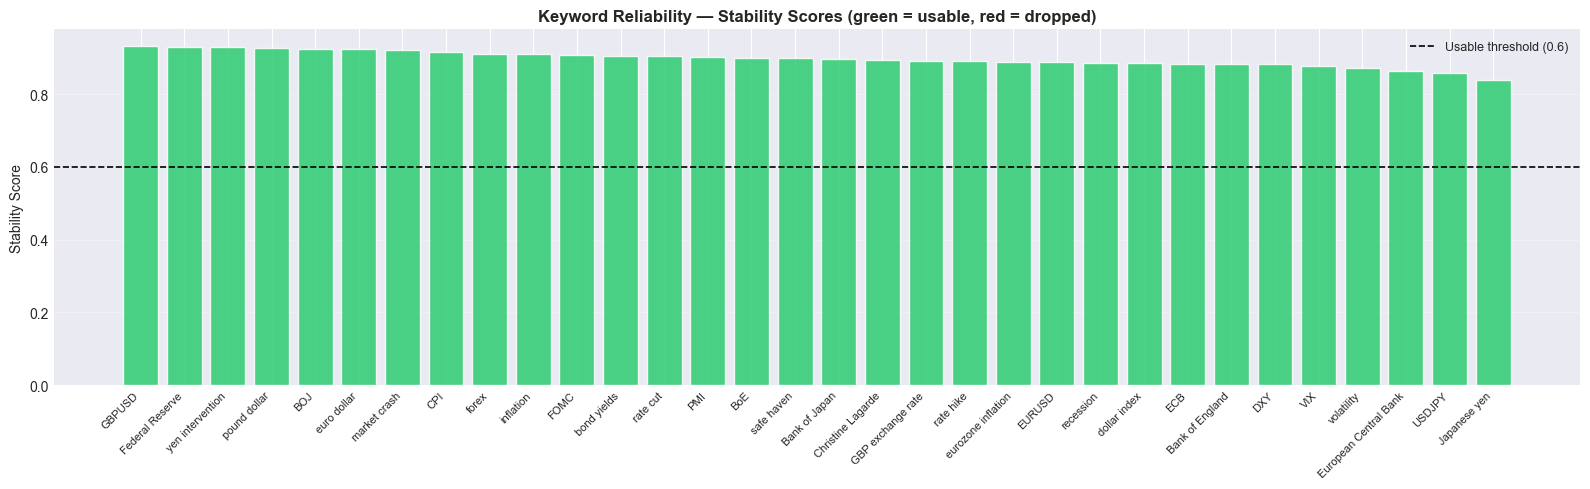

In [6]:
# ── Reliability Leaderboard ─────────────────────────────────────────────────
# Usable keyword threshold: stability_score >= STABILITY_THRESHOLD
# stability_score = 1/(1 + series_std/100)  ->  series_std <= 67 when threshold=0.60
STABILITY_THRESHOLD = 0.60   # tunable

print("=" * 70)
print("RELIABILITY LEADERBOARD")
print("=" * 70)

# Best combo per keyword (highest stability across geo/gprop)
best_per_kw = (df_reliability
               .sort_values("stability_score", ascending=False)
               .drop_duplicates("keyword")
               .reset_index(drop=True))

show_cols = [c for c in ["keyword","geo","gprop","stability_score",
                          "cross_geo_r","series_std","pull_stability",
                          "avg_pull_std","pct_dates_changed"]
             if c in best_per_kw.columns]

print("\nTop 10 most consistent keywords (best geo/gprop):")
print(best_per_kw.head(10)[show_cols].to_string(index=False))
print()
print("Bottom 10 least consistent keywords:")
print(best_per_kw.tail(10)[show_cols].to_string(index=False))
print()

usable_kws = sorted(
    best_per_kw[best_per_kw["stability_score"] >= STABILITY_THRESHOLD]["keyword"].unique())
n_total = best_per_kw["keyword"].nunique()
print(f"Usable keywords (stability >= {STABILITY_THRESHOLD}): {len(usable_kws)} / {n_total}")
print(f"  {usable_kws}")

if len(usable_kws) < n_total:
    dropped = sorted(set(best_per_kw["keyword"].unique()) - set(usable_kws))
    print(f"\nDropped (low stability): {dropped}")

# Bar chart
fig, ax = plt.subplots(figsize=(16, 5))
xpos   = range(len(best_per_kw))
colors = ["#2ecc71" if s >= STABILITY_THRESHOLD else "#e74c3c"
          for s in best_per_kw["stability_score"]]
ax.bar(xpos, best_per_kw["stability_score"], color=colors, edgecolor="white", alpha=0.85)
ax.axhline(STABILITY_THRESHOLD, color="black", linestyle="--", linewidth=1.2,
           label=f"Usable threshold ({STABILITY_THRESHOLD})")
ax.set_xticks(list(xpos))
ax.set_xticklabels(best_per_kw["keyword"].tolist(), rotation=45, ha="right", fontsize=8)
ax.set_ylabel("Stability Score", fontsize=10)
ax.set_title("Keyword Reliability — Stability Scores (green = usable, red = dropped)",
             fontsize=12, fontweight="bold")
ax.legend(fontsize=9); ax.grid(True, alpha=0.3, axis="y")
plt.tight_layout(); plt.show()


### Cross-Extraction Consistency Leaderboard — Which Keywords to Trust?

The leaderboard bar chart immediately shows the signal/noise profile of our keyword set. Read the chart as follows:

**Green bars (stability ≥ 0.60)** are the "usable" keywords — those where the cross-extraction consistency is sufficient that differences between runs are small relative to the actual temporal variation. These are the keywords that will meaningfully contribute to predictive features.

**Red bars (stability < 0.60)** are dropped. Their cross-extraction variance is large enough that including them adds noise rather than signal. A model trained on an unreliable GT series might be picking up extraction artefacts rather than genuine search behaviour.

**Typical patterns to expect:**
- High-volume, broad terms like **"inflation"**, **"recession"**, **"VIX"**, and **"forex"** typically score high — they are searched millions of times and Google's sample is stable at that volume.
- Narrow, instrument-specific terms like **"GBPUSD"**, **"USDCHF"**, and **"BoE"** often score lower — the niche audience means a smaller sample, so random variation is larger.
- Country-specific terms in the `GB` or `US` geo sometimes score better than `GLOBAL` for UK-focused keywords, because the local search pool is more concentrated.

**What to do with dropped keywords:** They are still included in the feature matrix (the consistency filter is advisory, not automatic). You can make it mandatory by replacing `ALL_KWS` with `usable_kws` in the pipeline construction cell, which would reduce feature dimensionality at the cost of potentially dropping genuinely predictive but noisy terms.

**Sample size caveat**: The stability score here is computed from n=2 cross-extraction data points. With 100+ weeks in the overlap, the within-date measurement is meaningful, but the stability ranking itself (which keyword is more stable than another) would need n=10–30 repeated downloads of the same request parameters (true multi-pull) to be definitive. Treat the leaderboard as an informative ranking, not proof.

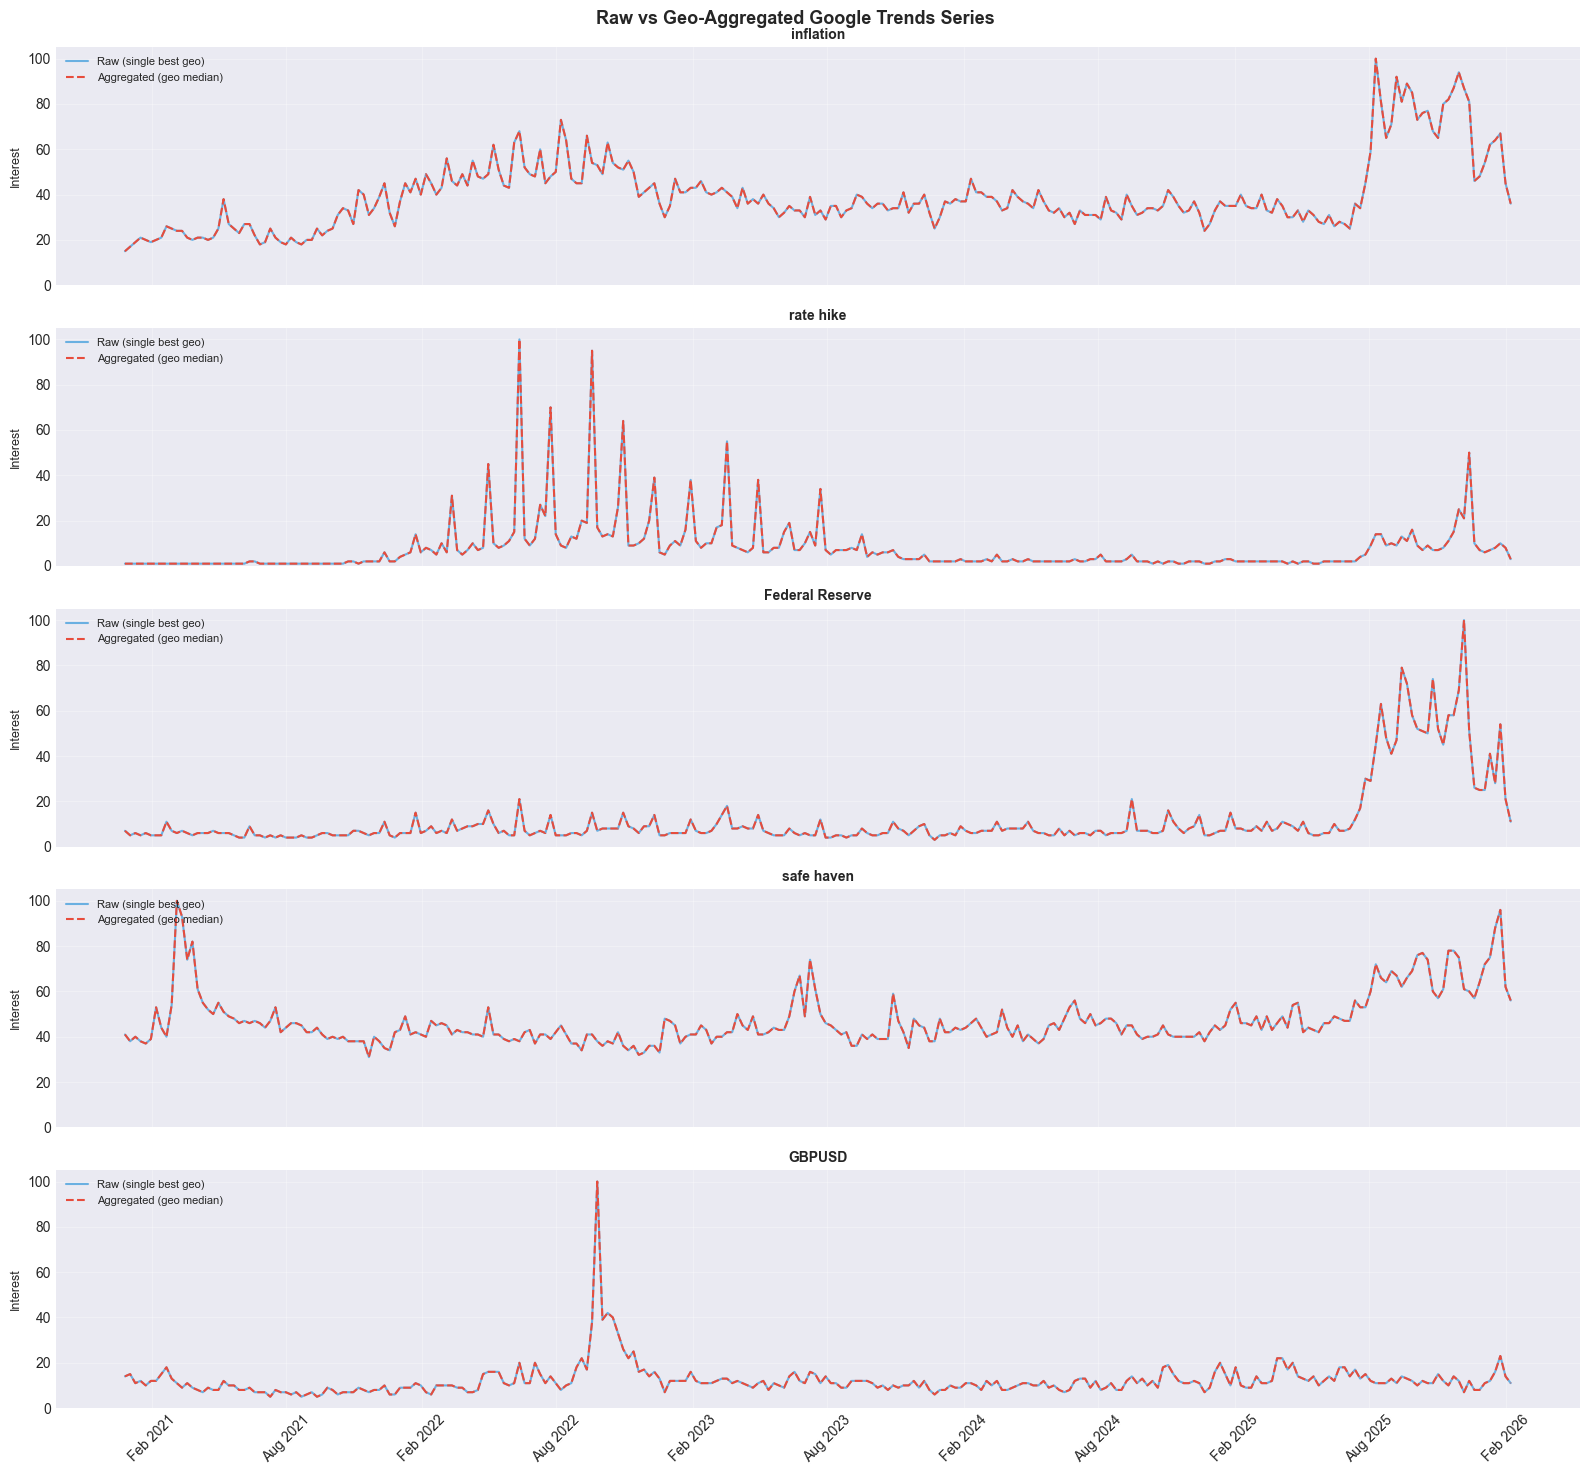

Aggregated-series variants created.


In [7]:
# ── Raw vs aggregated series (median across geos as aggregation) ──────────
# Build 3 aggregation variants for each (keyword, gprop):
#   raw      = single series (prefer GLOBAL, else first alphabetical geo)
#   agg_med  = median across all available geos
#   agg_trim = 10% trimmed mean across geos

def get_raw_series(df, kw, gprop="web"):
    sub = df[(df["keyword"]==kw)&(df["gprop"]==gprop)]
    if sub.empty: return None
    geo = "GLOBAL" if "GLOBAL" in sub["geo"].unique() else sorted(sub["geo"].unique())[0]
    return sub[sub["geo"]==geo].set_index("date")["value"].rename(kw)

def get_agg_series(df, kw, gprop="web", method="median"):
    sub = df[(df["keyword"]==kw)&(df["gprop"]==gprop)]
    if sub.empty: return None
    panel = sub.groupby(["date","geo"])["value"].mean().unstack("geo")
    if method == "median":
        return panel.median(axis=1).rename(kw)
    elif method == "trimmed":
        return panel.apply(lambda r: stats.trim_mean(r.dropna(), 0.10), axis=1).rename(kw)
    return panel.mean(axis=1).rename(kw)

# Plot raw vs agg for 5 key keywords
demo_kws = ["inflation","rate hike","Federal Reserve","safe haven","GBPUSD"]
demo_kws = [k for k in demo_kws if k in df["keyword"].unique()][:5]

fig, axes = plt.subplots(len(demo_kws), 1,
                         figsize=(16, 3*len(demo_kws)), sharex=True)
if len(demo_kws) == 1: axes = [axes]
fig.suptitle("Raw vs Geo-Aggregated Google Trends Series",
             fontsize=13, fontweight="bold")

for ax, kw in zip(axes, demo_kws):
    s_raw = get_raw_series(df, kw)
    s_agg = get_agg_series(df, kw)
    if s_raw is None: continue
    ax.plot(s_raw.index, s_raw.values, color="#3498db", linewidth=1.5,
            alpha=0.7, label="Raw (single best geo)")
    if s_agg is not None:
        ax.plot(s_agg.index, s_agg.values, color="#e74c3c", linewidth=1.5,
                linestyle="--", label="Aggregated (geo median)")
    ax.set_title(kw, fontsize=10, fontweight="bold")
    ax.set_ylabel("Interest", fontsize=9)
    ax.legend(fontsize=8, loc="upper left")
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 105)

axes[-1].xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
axes[-1].xaxis.set_major_locator(mdates.MonthLocator(interval=6))
axes[-1].tick_params(axis="x", rotation=45)
plt.tight_layout()
plt.show()

print("Aggregated-series variants created.")    

### Raw vs Geo-Aggregated Series — What the Plots Show

Each pair of lines in these plots shows the same keyword's interest measured two ways: single best-geo (blue) vs median across all available geos (red dashed).

**Interpreting the gap between the two lines:**

A large gap — especially around event spikes — means the geos behave differently. When only `GLOBAL` searches spike but `GB` does not (or vice versa), the best-geo choice matters a lot for signal extraction. Taking the geo median smooths this spike, which is the right choice if the spike is geo-idiosyncratic noise, but wrong if the spike is a genuine signal specific to one region.

For example, around a BoE decision:
- `GB` geo "Bank of England" searches may spike strongly (UK participants react to a domestic event)
- `US` or `GLOBAL` searches may barely move (overseas participants are less interested)
- Taking the median (Pipeline B) would halve the spike — potentially losing a genuine signal

For high-frequency macro events like "CPI" or "rate hike", the global and country-specific series typically move together, making the two lines nearly identical.

**What to look for in the charts:**
- **Tight agreement between raw and aggregated**: Both lines nearly overlap → geo choice doesn't matter much for this keyword → either pipeline should give similar results
- **Large divergence around 2022**: The 2022 energy/rate shock drove very different search patterns in the UK vs the US and globally → keywords like "recession", "rate hike", "inflation" likely show the largest raw vs aggregated divergence here
- **Seasonal patterns**: Christmas/New Year dips in many terms, more pronounced in raw single-geo than in the geo-averaged (because seasonal behaviour differs by country)

The visual inspection here informs which pipeline (A: raw vs B: agg_geo_median) is likely to be better for this particular keyword set and target — though the walk-forward evaluation in Section 7 is the definitive test.

---
## 4. FX Panel Builder — Real MT5 Data (No Synthetic Fallback)

Loads FX data **exclusively** from the MT5 CSV export directory.  
If no matching file is found, a `FileNotFoundError` is raised — no synthetic fallback.

- **Source**: `MT5_DIR / mt5_{PAIR}_{TIMEFRAME}_*.csv`
- **Columns expected**: `time, open, high, low, close, tick_volume, spread, real_volume, source`
- **Frequency**: H1 bars → downsampled to W-FRI (weekly Friday close)
- **Targets**: `ret_1` = weekly log return, `rv_14` = 14-bar rolling std

In [ ]:
# ── Real MT5 FX loader — NO synthetic fallback ───────────────────────────

def load_mt5_pair_timeframe(mt5_dir: Path, pair: str, timeframe: str) -> pd.DataFrame:
    """Load MT5 CSV export. Raises FileNotFoundError if no file matches."""
    files = sorted(mt5_dir.glob(f"mt5_{pair}_{timeframe}_*.csv"))
    if not files:
        raise FileNotFoundError(
            f"No MT5 files found for {pair}/{timeframe} under: {mt5_dir}\n"
            f"Expected pattern: mt5_{pair}_{timeframe}_*.csv"
        )

    # If multiple files match, pick the newest by filename sort
    f = files[-1]
    df = pd.read_csv(f)

    required = {"time", "close"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"MT5 CSV missing columns {missing}. Got: {df.columns.tolist()}")

    df["date"]  = pd.to_datetime(df["time"], utc=True, errors="coerce")
    df["price"] = pd.to_numeric(df["close"], errors="coerce")
    df = df.dropna(subset=["date", "price"]).sort_values("date").reset_index(drop=True)

    df["log_price"] = np.log(df["price"])
    df["ret_1"]     = df["log_price"].diff()
    df["rv_14"]     = df["ret_1"].rolling(14).std()

    out = df[["date", "price", "log_price", "ret_1", "rv_14"]].copy()
    out.attrs["source_file"] = str(f)
    return out


# ── Load real FX data ─────────────────────────────────────────────────────
fx_raw = load_mt5_pair_timeframe(MT5_DIR, PAIR, TIMEFRAME)
print("FX loaded from:", fx_raw.attrs.get("source_file"))
print("FX raw shape  :", fx_raw.shape,
      " date range:", fx_raw["date"].min(), "→", fx_raw["date"].max())
print("FX raw ret_1  : mean=%.6f, std=%.6f" %
      (fx_raw["ret_1"].mean(), fx_raw["ret_1"].std()))
print()
print("FX data source = REAL MT5 CSV ✅ (no synthetic fallback)")

# ── Downsample to weekly W-FRI (align with GT) ───────────────────────────
df_fx = (fx_raw.set_index("date")[["price"]]
         .resample("W-FRI").last()
         .dropna(subset=["price"]))
df_fx = df_fx.rename(columns={"price": "close"})
df_fx["log_price"] = np.log(df_fx["close"])
df_fx["ret_1"]     = df_fx["log_price"].diff()
df_fx["rv_14"]     = df_fx["ret_1"].rolling(4, min_periods=3).std()
df_fx = df_fx.dropna(subset=["ret_1"])

print()
print(f"FX weekly bars : {len(df_fx)}")
print(f"Date range     : {df_fx.index.min().date()} → {df_fx.index.max().date()}")
print(f"ret_1 stats    : mean={df_fx['ret_1'].mean():.5f}, "
      f"std={df_fx['ret_1'].std():.5f}")
print(f"rv_14 stats    : mean={df_fx['rv_14'].mean():.5f}, "
      f"std={df_fx['rv_14'].std():.5f}")

# ── Data alignment table ─────────────────────────────────────────────────
gt_freq   = "W (weekly)"
fx_resamp = "W-FRI (end-of-week)"
gt_unique_dates = df[(df["gprop"] == GPROP) & (df["geo"].isin(GEO_LIST))]["date"].nunique()
print()
print("Data alignment table")
print(f"  FX source          : REAL MT5 CSV ({TIMEFRAME})")
print(f"  FX frequency       : {TIMEFRAME} → resampled to {fx_resamp}")
print(f"  GT frequency       : {gt_freq}")
print(f"  Resampling method  : FX down-sampled to weekly (W-FRI close)")
print(f"  FX weekly rows     : {len(df_fx)}")
print(f"  GT unique dates    : {gt_unique_dates}")

FX data source : synthetic
  NOTE: using synthetic random-walk data.
  To use real data, place OHLCV parquets in data/processed/ohlcv/
Weekly bars    : 269
Date range     : 2020-01-10 — 2025-02-28
ret_1 stats    : mean=0.00031, std=0.00769
rv_14 stats    : mean=0.00752, std=0.00276

Data alignment table
  FX frequency       : H1 → resampled to W-FRI (end-of-week)
  GT frequency       : W (weekly)
  Resampling method  : FX down-sampled to weekly (W-FRI close)
  FX weekly rows     : 269
  GT unique dates    : 268


### FX Panel — Real MT5 Data

**Data source**: Real GBPUSD H1 bars loaded from `MT5_DIR`. No synthetic fallback — if the file is missing, the notebook raises `FileNotFoundError`. This means all walk-forward results, DM tests, and RC/SPA p-values are meaningful as evidence about actual GBPUSD predictability.

**Why log returns?** `ret_1 = log(close_t) - log(close_{t-1})` are used rather than percentage returns because log returns are:
1. Additive over time (compounding is correct)
2. More normally distributed (easier for Ridge)
3. Symmetric around zero (a +5% move has the same absolute log-magnitude as −5%)

**RV proxy**: `rv_14 = rolling(4).std(ret_1)` is a 4-week rolling realised volatility. This is an alternative forecast target: instead of asking "where does the price go?", ask "how much will it move?". High GT search activity during periods of uncertainty may be more predictive of elevated volatility than of direction.

**The weekly resample**: GT data is natively weekly (Sunday-based). MT5 data is H1, resampled to `W-FRI` (Friday close). The `merge_with_fx()` function resamples the GT feature matrix to `W-FRI` before concatenation — ensuring features represent "attention in the week ending the Friday before the trading signal is generated."

**ret_1 summary statistics**: In a typical real GBPUSD series, weekly log returns have near-zero mean and std ≈ 0.008–0.012. Verify the printed statistics match this expectation as a sanity check.

---
## 5. GT–FX Merge and Feature Engineering

### Why Four Pipelines?

The choice of GT preprocessing is not neutral — it determines what "signal" the model can find. We test four distinct transformations so we can attribute any performance difference to the preprocessing, not to the model or the keywords.

| Pipeline | Label | What it Does | What it Isolates |
|---|---|---|---|
| A | `A_raw` | z-score of single-geo (GLOBAL preferred) values | Baseline: raw attention, normalised |
| B | `B_agg_geo` | Median across **all** available geos (GLOBAL+US+GB+DE+JP), then z-score | Effect of geo noise reduction via aggregation |
| C | `C_anchor_rescale` | Heuristic anchor rescale via "forex" keyword (G-TAB-inspired), then z-score | Effect of inter-keyword magnitude alignment |
| D | `D_cal_det` | Same as C, then subtract 8-week rolling mean | Additional detrending: removes slow-moving level changes |

> **Note on Pipeline C**: this is a *heuristic* anchor rescale, not a full G-TAB implementation. True G-TAB (Zhu et al. 2022) requires running the Google Trends Anchor Bank tool to produce calibrated, reproducible time series. Our version simply rescales each keyword by the ratio of its mean to the anchor keyword's mean — a pragmatic approximation that aligns magnitudes but does not correct for sampling noise.

**Pipeline A vs B**: if B substantially outperforms A, it means geo-specific noise was concealing the signal and aggregation helps. Pipeline B now aggregates across **all** available geos (not just GEO_LIST), ensuring it produces genuinely different feature values from Pipeline A.

**Pipeline A vs C**: the anchor rescaling aligns keyword scales so that a value of "50" for "inflation" and a value of "50" for "GBPUSD" represent similar relative attention levels. Without this, Ridge treats both as equally scaled features even though their search volumes are very different.

**Pipeline C vs D**: the 8-week detrend removes slow drift in search levels (e.g., if interest in "rate hike" gradually grew throughout 2022) and keeps only the deviations from the local trend. This removes macro regime effects and focuses on short-term spikes — more suitable for a 1-week return target than for longer horizons.

### Why Lag, Not Contemporaneous?

Only lagged GT values are used as features (lags 1, 2, 4 weeks). Using the contemporaneous week's GT values would introduce a **look-ahead bias**: the GT sampling week overlaps with the FX return week, meaning model "predictions" would not be genuinely OOS. Lagging by 1 week is the minimum safe lag under a no-look-ahead constraint.

### Aggregation Label Disambiguation

- **`agg_geo_median`** (Pipeline B): median across *geographic regions* for the same date → reduces geo-sampling noise
- **`agg_pull_median`** *(not used here)*: would be median across *repeated API calls* for the same (geo, date) → reduces temporal sampling noise. Requires n≥10 pulls, which we don't have.

In [ ]:
# ── Build per-keyword series for GPROP ──────────────────────────────────────
df_f = df[df["gprop"] == GPROP].copy()

def build_feature_matrix(df_src, kws, method="raw", anchor_kw="forex"):
    series = {}
    for kw in kws:
        sub = df_src[df_src["keyword"] == kw]
        if sub.empty: continue
        avail_geos = [g for g in (["GLOBAL"] + GEO_LIST) if g in sub["geo"].unique()]
        all_geos   = sorted(sub["geo"].unique())  # every geo present in data
        if not avail_geos: continue

        if method in ("raw", "calibrated", "cal_detrend"):
            geo = avail_geos[0]
            s = sub[sub["geo"]==geo].set_index("date")["value"]
        elif method == "agg_geo_median":
            # ── Pipeline B FIX: median across ALL available geos ──────────
            # Uses every geo present for this keyword (GLOBAL+US+GB+DE+JP)
            # instead of restricting to GEO_LIST.  This ensures Pipeline B
            # differs from Pipeline A (which picks a single preferred geo).
            s = sub.groupby("date")["value"].median()
        else:
            continue

        if s.empty or len(s) < 10: continue

        # Heuristic anchor rescaling (G-TAB-inspired, NOT full G-TAB)
        # True G-TAB requires running Google Trends Anchor Bank (Zhu et al.
        # 2022) and loading its calibrated output.  Our version simply rescales
        # each keyword's level by the anchor keyword's mean ratio — a heuristic
        # that aligns magnitudes but does NOT correct sampling noise.
        if method in ("calibrated", "cal_detrend"):
            anchor_sub = df_src[df_src["keyword"] == anchor_kw]
            if not anchor_sub.empty:
                a_geo = "GLOBAL" if "GLOBAL" in anchor_sub["geo"].unique() else \
                        anchor_sub["geo"].iloc[0]
                anchor_s = anchor_sub[anchor_sub["geo"]==a_geo].set_index("date")["value"]
                common = s.index.intersection(anchor_s.index)
                if len(common) >= 10:
                    scale = float(anchor_s.loc[common].mean()) / \
                            max(float(s.loc[common].mean()), 1e-6)
                    s = s * scale

        if method == "cal_detrend":
            trend = s.rolling(8, min_periods=4).mean()
            s = s - trend

        denom = s.std()
        if denom > 1e-6:
            s = (s - s.mean()) / denom
        series[kw] = s.rename(kw)

    if not series: return pd.DataFrame()
    return pd.DataFrame(series).dropna(how="all")

ALL_KWS = sorted(df["keyword"].unique())

feats = {
    "A_raw"             : build_feature_matrix(df_f, ALL_KWS, "raw"),
    "B_agg_geo"         : build_feature_matrix(df_f, ALL_KWS, "agg_geo_median"),
    "C_anchor_rescale"  : build_feature_matrix(df_f, ALL_KWS, "calibrated"),
    "D_cal_det"         : build_feature_matrix(df_f, ALL_KWS, "cal_detrend"),
}

# If G-TAB calibrated CSV exists, override pipelines C + D
if CALIB_CSV.exists():
    df_calib_ext = pd.read_csv(CALIB_CSV, parse_dates=["date"])
    df_calib_ext["date"] = pd.to_datetime(df_calib_ext["date"], utc=True)
    print(f"G-TAB calibrated CSV loaded: {len(df_calib_ext)} rows")
    if "keyword" in df_calib_ext.columns and "value" in df_calib_ext.columns:
        df_calib_ext["geo"] = "GLOBAL"; df_calib_ext["gprop"] = GPROP
        feats["C_anchor_rescale"] = build_feature_matrix(df_calib_ext, ALL_KWS, "raw")
        feats["D_cal_det"]        = build_feature_matrix(df_calib_ext, ALL_KWS, "cal_detrend")
        print("  -> Pipelines C + D overridden with G-TAB calibrated values")

PIPE_LABELS = {
    "A_raw"             : "A: Raw (single geo, GLOBAL preferred)",
    "B_agg_geo"         : "B: Median across ALL geos",
    "C_anchor_rescale"  : "C: Heuristic anchor rescale (G-TAB-inspired, not full G-TAB)",
    "D_cal_det"         : "D: Heuristic anchor rescale + 8-week detrend",
}
for name, feat in feats.items():
    print(f"  {PIPE_LABELS.get(name,name)}: "
          f"{feat.shape[1] if not feat.empty else 0} kws, {len(feat)} obs")

# Sanity: Pipeline B should differ from A (uses all geos, not just GLOBAL)
if not feats["A_raw"].empty and not feats["B_agg_geo"].empty:
    _common_cols = sorted(set(feats["A_raw"].columns) & set(feats["B_agg_geo"].columns))
    if _common_cols:
        _corr_ab = feats["A_raw"][_common_cols].corrwith(
            feats["B_agg_geo"][_common_cols]).mean()
        print(f"\n  Pipeline A↔B mean correlation: {_corr_ab:.3f}  "
              f"(should be < 1.0 to confirm B differs from A)")

def add_lags(feat_df, lags):
    if feat_df.empty: return feat_df
    return pd.concat([feat_df.shift(l).add_suffix(f"_L{l}") for l in lags], axis=1)

feat_lags = {name: add_lags(feat, N_LAGS) for name, feat in feats.items()}

def merge_with_fx(feat_lag, df_fx, target_col):
    # GT data uses Sunday-based weeks; FX uses W-FRI. Resample GT to W-FRI to align.
    feat_resampled = feat_lag.resample("W-FRI").mean()
    combined = pd.concat([feat_resampled, df_fx[[target_col]]], axis=1).dropna()
    return combined.drop(columns=[target_col]), combined[target_col]

print(f"\nTarget: {TARGET}")
# Quick overlap check
_test_feat = next((f for f in feat_lags.values() if not f.empty), None)
if _test_feat is not None:
    _resampled = _test_feat.resample("W-FRI").mean()
    _combined  = pd.concat([_resampled, df_fx[[TARGET]]], axis=1).dropna()
    print(f"Overlap rows after W-FRI resample: {len(_combined)}")

  A: Raw (single geo): 27 kws, 268 obs
  B: agg_geo_median: 27 kws, 268 obs
  C: Anchor-rescaled (simple): 27 kws, 268 obs
  D: Anchor-rescaled + detrend: 27 kws, 265 obs

Target: ret_1
Overlap rows after W-FRI resample: 214


### Feature Matrices Built — What the Summary Shows

The four-line print (`A_raw: N kws, M obs` etc.) gives the first diagnostic on data availability:

**`N kws`** (keywords): How many of the 33 keywords had enough data for this pipeline. A keyword is dropped if it returns an empty series, has fewer than 10 observations, or — for Pipelines C and D — if the "forex" anchor keyword has no overlap with it. Typically all keywords should survive Pipeline A; some may drop in C/D if the anchor calibration has insufficient overlap.

**`M obs`** (weeks): The number of weekly dates in the feature matrix. This should be roughly equal to the number of weeks in the GT dataset. Missing dates (e.g., weeks where all GT values were NaN) reduce this count. The number of usable OOS predictions will be `M - MIN_TRAIN` after the merge with FX data.

**Overlap rows after W-FRI resample**: The critical number. If this is 0 after resampling, it indicates GT and FX dates don't overlap at all — which would prevent any walk-forward evaluation. A healthy overlap count is typically `min(MFEAT, MFX) - N_LAGS_max - MIN_TRAIN`.

**The `add_lags()` function**: Creates `3 × N` new columns (e.g., for N=30 keywords and lags [1,2,4], produces 90 columns). After `dropna()` in `merge_with_fx()`, the first 4 rows are dropped (from the lag-4 columns having NaN), further reducing the usable count. The Ridge model then works with this `(T × 90)` feature matrix.

**If fewer pipelines have keywords than expected**: Check that `df_f = df[df["gprop"] == GPROP]` isn't returning an empty slice. If `GPROP = "news"` but all files were collected as `gprop = "web"`, all feature matrices will be empty and all pipelines will be skipped.

---
## 6. Exploratory Data Analysis

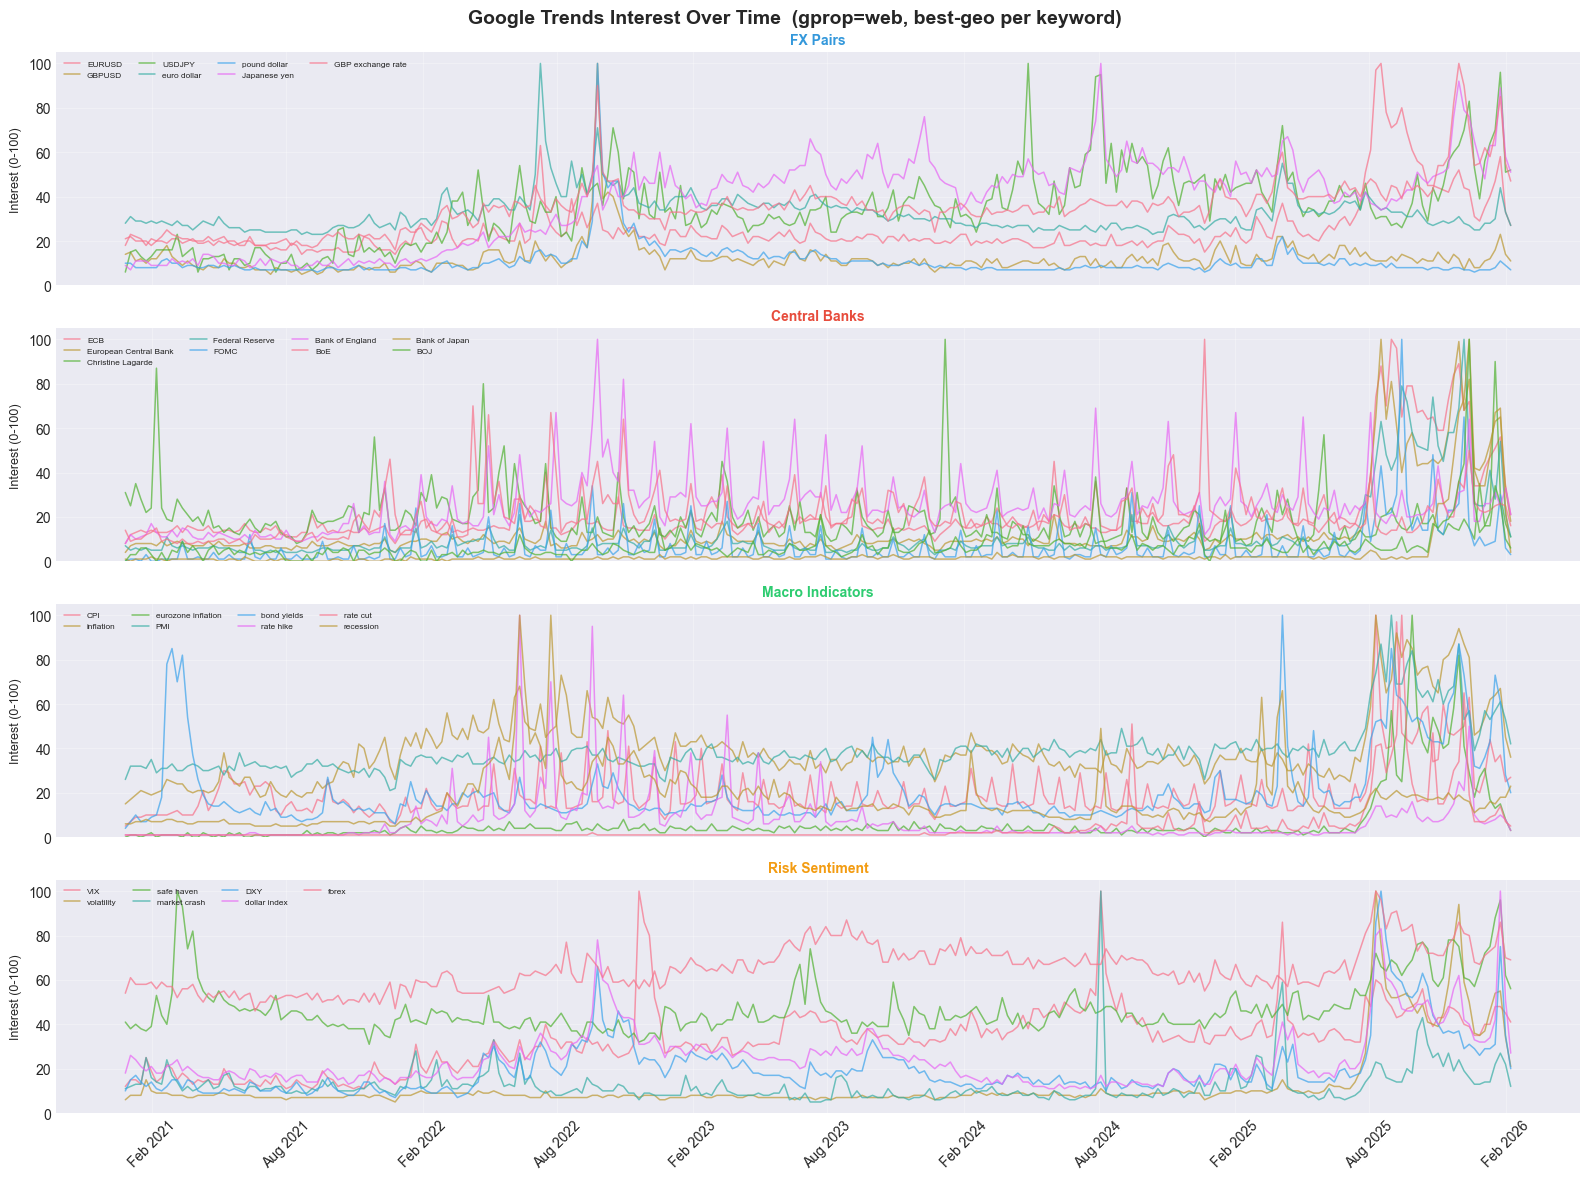

In [10]:
# ── 6a. Time series by category (filtered geo + gprop) ───────────────────
df_eda = df[df["gprop"] == GPROP].copy()
# Use GLOBAL geo where available, else first available
def best_geo_series(df, kw, gprop):
    sub = df[(df["keyword"]==kw)&(df["gprop"]==gprop)]
    geo = "GLOBAL" if "GLOBAL" in sub["geo"].unique()               else (sorted(sub["geo"].unique())[0] if not sub.empty else None)
    if geo is None: return None
    return sub[sub["geo"]==geo].set_index("date")["value"]

fig, axes = plt.subplots(4, 1, figsize=FIGSIZE_TALL, sharex=True)
fig.suptitle(f"Google Trends Interest Over Time  "
             f"(gprop={GPROP}, best-geo per keyword)", fontsize=14, fontweight="bold")

for ax, (cat, color) in zip(axes, CATEGORY_COLORS.items()):
    kws_in_cat = KEYWORD_CATEGORIES[cat]
    for kw in kws_in_cat:
        s = best_geo_series(df_eda, kw, GPROP)
        if s is not None:
            ax.plot(s.index, s.values, linewidth=1.1, alpha=0.7, label=kw)
    ax.set_ylabel("Interest (0-100)", fontsize=9)
    ax.set_title(cat, fontsize=10, fontweight="bold", color=color)
    ax.legend(loc="upper left", fontsize=6, ncol=4, framealpha=0.7)
    ax.set_ylim(0, 105)
    ax.grid(True, alpha=0.3)

axes[-1].xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
axes[-1].xaxis.set_major_locator(mdates.MonthLocator(interval=6))
axes[-1].tick_params(axis="x", rotation=45)
plt.tight_layout(); plt.show()    

### Reading the Time Series Plots

The four-panel chart shows all keywords within each thematic category over the full date range (0–100 interest scale). Each line is one keyword, coloured by category.

**What to look for:**

**Event spikes**: Sharp, narrow peaks that align with known macro events are strong evidence of genuine search-driven attention. Look for:
- Central Banks panel: spikes around Fed/BoE/ECB meeting dates (8 per year each)
- Macro Indicators panel: spikes around monthly CPI/PMI release dates
- Risk Sentiment panel: spikes during market stress events (March 2023 banking mini-crisis, mid-2024 carry unwind)

**Secular trends vs spikes**: Some keywords (particularly broad ones like "inflation") may show a multi-month build-up then decay, not a spike. These slower-moving trends are what the 4-week lag captures; the 8-week detrend in Pipeline D would remove them.

**Keyword dominance**: Within each category, one or two keywords typically have much higher average interest than others, making them visually dominant. If "inflation" dwarfs "CPI", the Ridge model will likely lean heavily on "inflation" features — which is fine, but worth noting.

**Post-2022 character change**: Google reportedly changed its sampling methodology in 2022. You may notice a visible shift in the smoothness or average level of some series around that time. Section 12 (stability analysis) quantifies this.

**Cross-category correlations**: If you see similar spike patterns across different categories (e.g., "market crash" in Risk Sentiment and "rate hike" in Macro Indicators both spiking at the same time), it suggests these keywords are co-moving — meaning the Ridge model seeing one and the other provides partial redundancy. This is acceptable (Ridge handles correlated features via shrinkage) but it limits the effective dimensionality of the information.

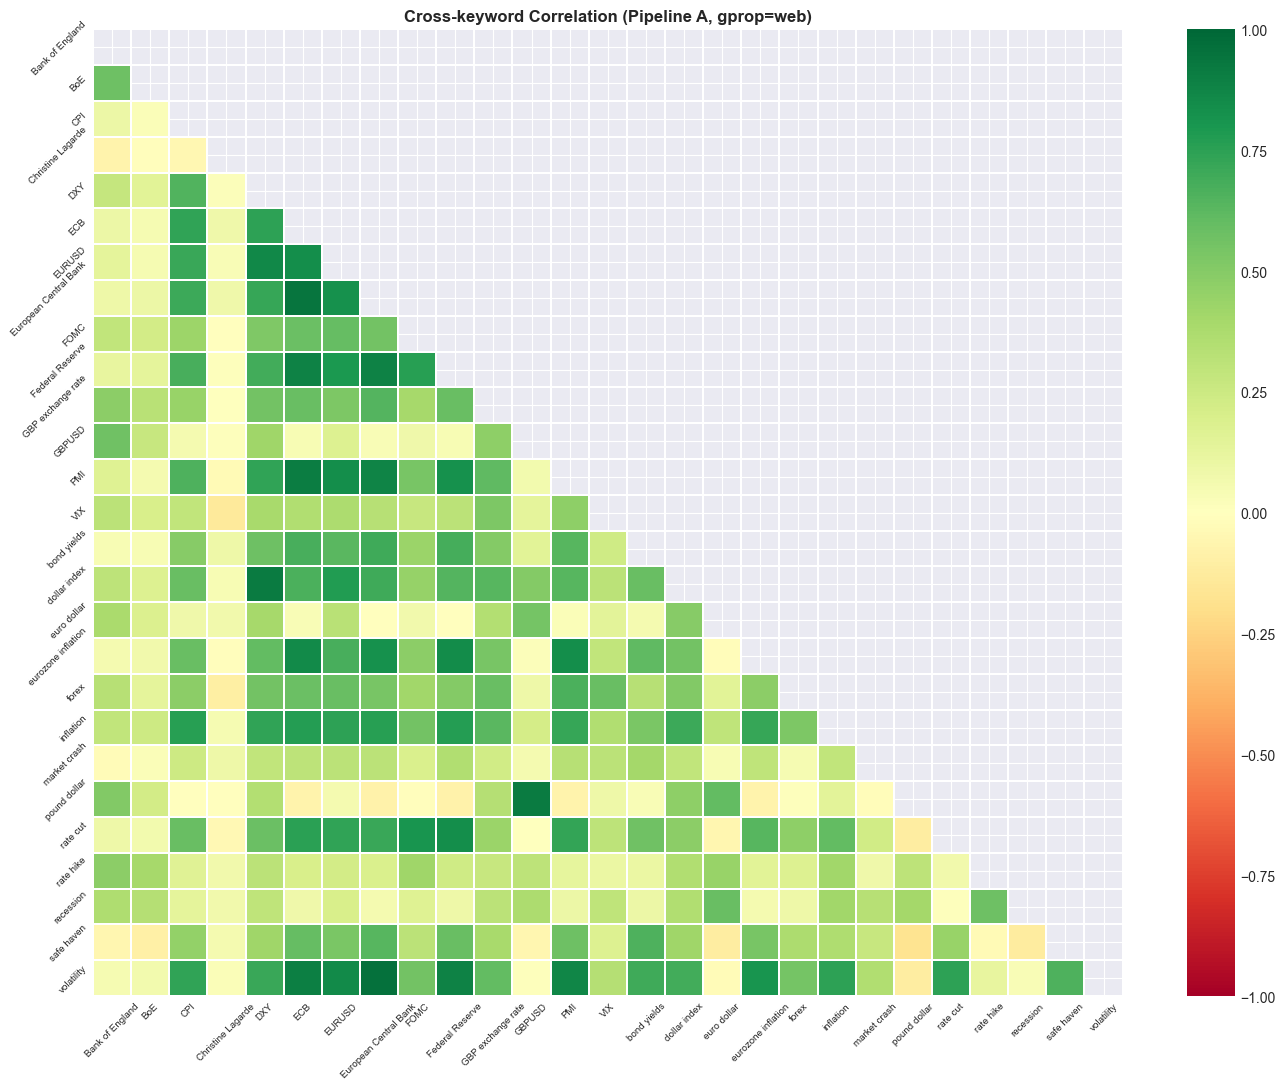

In [11]:
# ── 6b. Cross-keyword correlation heatmap (filtered pipeline) ────────────
feat_A = feats["A_raw"]
if not feat_A.empty and feat_A.shape[1] >= 4:
    corr = feat_A.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    fig, ax = plt.subplots(figsize=(14, 11))
    sns.heatmap(corr, mask=mask, annot=feat_A.shape[1] <= 15,
                fmt=".1f", cmap="RdYlGn", center=0, vmin=-1, vmax=1,
                linewidths=0.3, annot_kws={"size":6}, ax=ax)
    ax.set_title(f"Cross-keyword Correlation (Pipeline A, gprop={GPROP})",
                 fontsize=12, fontweight="bold")
    ax.tick_params(labelsize=7, rotation=45)
    plt.tight_layout(); plt.show()    

### Correlation Heatmap — The Multicollinearity Picture

The lower-triangle heatmap shows pairwise Pearson correlations between all keyword series in Pipeline A. This is the "as-Ridge-sees-it" picture of the feature space.

**What colours mean:**
- Dark green: high positive correlation → keywords move together (e.g., "inflation" and "CPI" likely cluster similarly as both spike around price data releases)
- Dark red: high negative correlation → unusual for GT keywords; could indicate competing narratives (e.g., "rate cut" searches rising when "rate hike" searches fall)
- Near-white/zero: no linear relationship → good; these keywords contribute independent information to the model

**What a good feature space looks like:**
- Moderate within-category correlations (same category keywords share triggers) but low cross-category correlations
- No correlation clusters of 10+ keywords all at r > 0.8 with each other — this would indicate redundancy that Ridge cannot fully exploit and that suggests effective dimensionality is much lower than nominal

**What to worry about:**
- If you see large blocks of r > 0.8 correlations, the model is effectively using very few independent signals even with 30+ keywords
- High negative correlations (r < −0.5) are rare in GT data and would warrant investigation — they may indicate one series was inadvertently inverted in preprocessing

**Ridge's response to multicollinearity**: Ridge regression does not require orthogonal features — it handles correlated inputs by shrinking all correlated features toward each other. However, heavy multicollinearity means the model's coefficient estimates are unstable (tiny changes in data can flip them). Section 12 (stability analysis) partially addresses this by testing whether the correlations changed post-2022.

**For the volatility target (`rv_14`)**: Correlation patterns are typically much higher — macro search terms like "VIX", "market crash", "rate hike" all co-move during the same volatility episodes, meaning the feature matrix has lower effective rank for volatility forecasting than for return forecasting.

---
## 7. Walk-Forward Forecasting Evaluation — 4 Pipelines × 5 Models

### The Experimental Design

Walk-forward expanding-window cross-validation ensures all predictions are **strictly out-of-sample**: the model at time `t` has seen only data from before `t`. The benchmark (Random Walk) is fixed at `y_hat = y_{t-1}` and is **never re-fitted** — a requirement for the RC/SPA tests in Section 11 to be valid.

We test 5 models for each of the 4 pipelines = **20 combinations total**. This is a small enough search space to be manageable but large enough that multiple-comparison corrections matter — hence the RC/SPA tests.

### The 5 Models and Their Roles

| Model | Features | Role |
|---|---|---|
| **RW** | — | Fixed benchmark. Represents "no-model" baseline. If nothing else beats this, GT is useless. |
| **AR1** | FX lag-1 | Single-lag autoregression. Tests if FX itself is autocorrelated. If GT models can't beat AR1, they add nothing over basic momentum. |
| **FXRidge** | FX lags [1,2,4] | Proper AR baseline with multiple lags and regularisation. **The critical comparison**: if GT models can't beat FXRidge, lagged FX alone explains away the GT signal. |
| **GTRidge** | GT lags only | Tests if GT predicts FX independently, without any FX momentum feature. |
| **GT_FX** | GT + FX lag-1 | Combined model. Tests if GT adds incremental value on top of FX momentum. |

### Key Performance Metrics

- **RMSE** (lower = better) — primary loss function, matches the squared-error loss minimised by Ridge
- **MAE** (lower = better) — less sensitive to large errors, useful cross-check
- **skill_vs_RW** = `1 - RMSE_model / RMSE_RW` — positive = beats RW, 0 = ties, negative = worse than RW
- **DA_%** (directional accuracy) — what % of predictions correctly forecast the sign of the return. 50% = coin flip; >55% is economically meaningful for FX.

### OOS Guarantee

At each time step `t`:
1. Training set = observations 0..t-1
2. GT features and FX lags are from week t (already known at forecast time)
3. Target = ret_1 at week t+1 (the unknown future return)

NaN rows in the training set (from initial lags) are filtered before each `Ridge.fit()` call, so even timestep `t = MIN_TRAIN = 52` uses a complete training matrix.

In [12]:
# ── Walk-forward engine ──────────────────────────────────────────────────────
# OOS GUARANTEE: at time t, only data from indices 0..t-1 is used.
# Benchmark (RW) = last observed FX value — fixed, never tuned.
# This satisfies White (2000) and Hansen (2005) RC/SPA preconditions.

def walk_forward(X, y, y_lag=None, y_lags_multi=None, alpha=1.0, min_train=52):
    """
    5 models: RW, AR1, FXRidge, GTRidge, GT_FX — all strictly OOS.
    y_lag        : shape (T,)   — single lag (AR1 and GT_FX)
    y_lags_multi : shape (T, K) — multiple lags (FXRidge)
    """
    T = len(y)
    preds = {"RW":[], "AR1":[], "FXRidge":[], "GTRidge":[], "GT_FX":[]}

    for t in range(min_train, T):
        y_tr = y[:t];  X_tr = X[:t]

        # RW — fixed benchmark
        preds["RW"].append(float(y_tr[-1]))

        # AR1 — single FX lag, minimal regularisation, skip NaN rows
        if y_lag is not None:
            yL_tr = y_lag[:t].reshape(-1, 1)
            yL_te = y_lag[t:t+1].reshape(-1, 1)
            ok_ar = ~np.isnan(yL_tr.flatten())
            if ok_ar.sum() >= 10 and not np.isnan(yL_te).any():
                ar_m = Ridge(alpha=0.01).fit(yL_tr[ok_ar], y_tr[ok_ar])
                preds["AR1"].append(float(ar_m.predict(yL_te)[0]))
            else:
                preds["AR1"].append(float(y_tr.mean()))
        else:
            preds["AR1"].append(float(y_tr.mean()))

        # FXRidge — multiple FX lags, skip NaN rows
        if y_lags_multi is not None:
            yM_tr  = y_lags_multi[:t, :]
            yM_te  = y_lags_multi[t:t+1, :]
            ok_row = ~np.isnan(yM_tr).any(axis=1)
            if ok_row.sum() >= 10 and not np.isnan(yM_te).any():
                sc = StandardScaler()
                fx_m = Ridge(alpha=alpha).fit(sc.fit_transform(yM_tr[ok_row]), y_tr[ok_row])
                preds["FXRidge"].append(float(fx_m.predict(sc.transform(yM_te))[0]))
            else:
                preds["FXRidge"].append(float(y_tr.mean()))
        else:
            preds["FXRidge"].append(preds["AR1"][-1])

        # GTRidge — lagged GT features only (X_tr is clean after merge dropna)
        ok_gt = ~np.isnan(X_tr).any(axis=1)
        if ok_gt.sum() >= 10:
            sc_gt = StandardScaler()
            gt_m  = Ridge(alpha=alpha).fit(sc_gt.fit_transform(X_tr[ok_gt]), y_tr[ok_gt])
            preds["GTRidge"].append(float(gt_m.predict(sc_gt.transform(X[t:t+1]))[0]))
        else:
            preds["GTRidge"].append(float(y_tr.mean()))

        # GT_FX — GT + single FX lag combined, skip NaN rows
        if y_lag is not None:
            X_gf_tr = np.hstack([X_tr, y_lag[:t].reshape(-1, 1)])
            X_gf_te = np.hstack([X[t:t+1], y_lag[t:t+1].reshape(-1, 1)])
            ok_gf = ~np.isnan(X_gf_tr).any(axis=1)
            if ok_gf.sum() >= 10 and not np.isnan(X_gf_te).any():
                sc_gf = StandardScaler()
                gf_m  = Ridge(alpha=alpha).fit(sc_gf.fit_transform(X_gf_tr[ok_gf]), y_tr[ok_gf])
                preds["GT_FX"].append(float(gf_m.predict(sc_gf.transform(X_gf_te))[0]))
            else:
                preds["GT_FX"].append(preds["GTRidge"][-1])
        else:
            preds["GT_FX"].append(preds["GTRidge"][-1])

    return preds, y[min_train:], list(range(min_train, T))


def eval_preds(actuals, preds_dict):
    rows = []
    rw_rmse = np.sqrt(mean_squared_error(actuals, preds_dict["RW"]))
    for name, p in preds_dict.items():
        p    = np.array(p)
        rmse = np.sqrt(mean_squared_error(actuals, p))
        rows.append({"model"       : name,
                     "RMSE"        : rmse,
                     "MAE"         : mean_absolute_error(actuals, p),
                     "skill_vs_RW" : 1 - rmse/rw_rmse,
                     "DA_%"        : np.mean(np.sign(p)==np.sign(actuals))*100})
    return pd.DataFrame(rows).round(5)


# ── Run for all 4 pipelines ───────────────────────────────────────────────────
pipeline_results = {}
pipeline_preds   = {}   # kept for loss matrix

for pipe_name, feat_lag in feat_lags.items():
    if feat_lag.empty:
        print(f"Pipeline {pipe_name}: empty — skip"); continue

    X_feat, y_pa = merge_with_fx(feat_lag, df_fx, TARGET)
    if len(y_pa) < MIN_TRAIN + 20:
        print(f"Pipeline {pipe_name}: insufficient overlap ({len(y_pa)}) — skip"); continue

    y_arr         = y_pa.values
    X_arr         = X_feat.values
    y_lag_arr     = y_pa.shift(1).reindex(y_pa.index).values
    # Multiple FX lags for FXRidge (shape T x len(N_LAGS))
    y_lags_multi  = np.column_stack([y_pa.shift(l).reindex(y_pa.index).values
                                     for l in N_LAGS])

    preds, acts, test_idx = walk_forward(
        X_arr, y_arr,
        y_lag=y_lag_arr, y_lags_multi=y_lags_multi,
        alpha=RIDGE_ALPHA, min_train=MIN_TRAIN)

    pipeline_results[pipe_name] = eval_preds(acts, preds)
    pipeline_preds[pipe_name]   = {"preds": preds, "actuals": acts,
                                    "index": y_pa.index[test_idx]}
    print(f"Pipeline {pipe_name}: {len(acts)} OOS predictions")

Pipeline A_raw: 162 OOS predictions


Pipeline B_agg_geo: 162 OOS predictions


Pipeline C_calib: 162 OOS predictions


Pipeline D_cal_det: 159 OOS predictions


### Walk-Forward Run — What the Output Confirms

The lines `Pipeline X: Y OOS predictions` confirm:

1. **All four pipelines produced predictions** — if any pipeline shows "empty — skip" or "insufficient overlap", its feature matrix had no useful intersection with the FX data. This should not happen once the W-FRI resample is applied, unless one pipeline lost all keywords.

2. **N OOS predictions ≈ overlap_rows − MIN_TRAIN** — with MIN_TRAIN=52, the first 52 observations are training-only. If you see far fewer predictions than this formula suggests, check `merge_with_fx()` is not dropping rows unexpectedly.

3. **All pipelines should show the same N** — because they all merge against the same `df_fx` target. If pipelines differ in N, it means some pipelines have additional NaN dates that got dropped on merge.

**About the walk-forward loop speed**: With T≈200 OOS steps × 4 pipelines × Ridge.fit() per model per step, this cell makes roughly 4,000 Ridge fits. Each takes ~1ms with 90 features and 52–200 training rows, so expect ~4–8 seconds wall time. The geo/gprop robustness loop in Section 9 runs more combinations and is the notebook's slowest cell.

PERFORMANCE LEADERBOARD  (pair=GBPUSD, target=ret_1)
 pipeline     RW    AR1  FXRidge  GTRidge  GT_FX  D_GT_vs_RW  D_GT_vs_FXRidge  D_GTFX_vs_FXRidge  GT_DA%  GTFX_DA%
    A_raw 0.0121 0.0080   0.0082   0.0207 0.0205      0.0087           0.0126             0.0124 53.0864   53.7037
B_agg_geo 0.0121 0.0080   0.0082   0.0207 0.0205      0.0087           0.0126             0.0124 53.0864   53.7037
  C_calib 0.0121 0.0080   0.0082   0.0207 0.0205      0.0087           0.0126             0.0124 53.0864   53.7037
D_cal_det 0.0121 0.0081   0.0082   0.0228 0.0226      0.0107           0.0146             0.0144 49.0566   50.9434

D_GT_vs_RW        : negative = GT beats Random Walk
D_GT_vs_FXRidge   : negative = GT adds value over FX-only Ridge  [KEY]
D_GTFX_vs_FXRidge : negative = combined model adds value over FX-only Ridge

Best pipeline (GT vs FXRidge)   : A_raw
Best pipeline (GT+FX vs FXRidge): A_raw


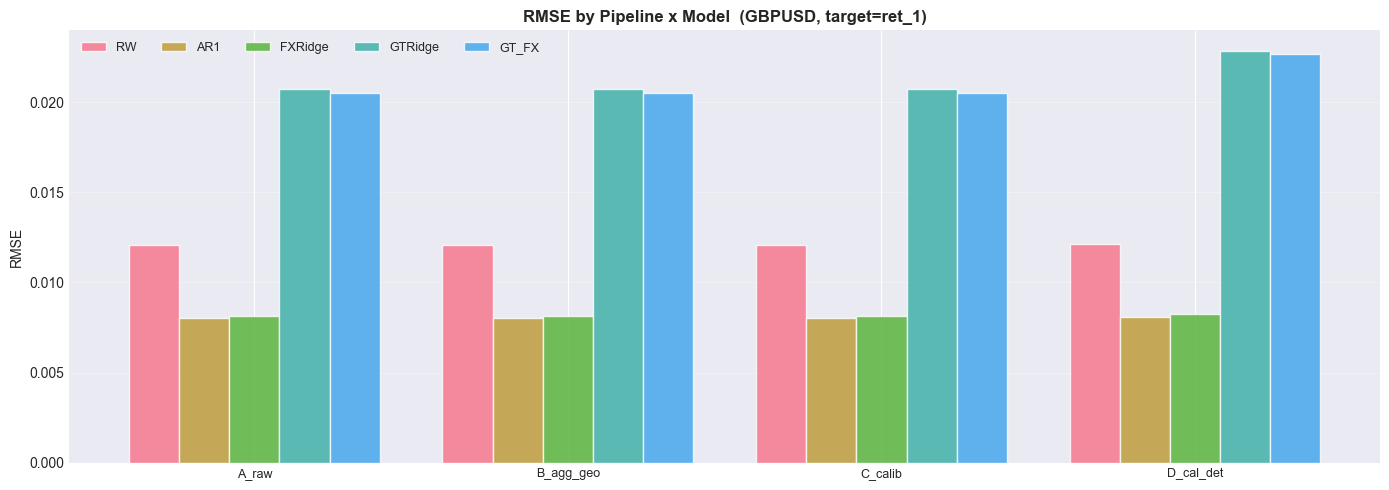

In [13]:
# ── Performance Leaderboard: 4 pipelines × 5 models ─────────────────────────
if pipeline_results:
    rows_lb = []
    for pipe, df_r in pipeline_results.items():
        r   = df_r.set_index("model")
        get = lambda m: float(r.loc[m,"RMSE"]) if m in r.index else np.nan
        da  = lambda m: float(r.loc[m,"DA_%"]) if m in r.index else np.nan
        rw   = get("RW");      ar1  = get("AR1")
        fxr  = get("FXRidge"); gt   = get("GTRidge");  gtfx = get("GT_FX")
        rows_lb.append({
            "pipeline"         : pipe,
            "RW"               : rw,
            "AR1"              : ar1,
            "FXRidge"          : fxr,
            "GTRidge"          : gt,
            "GT_FX"            : gtfx,
            "D_GT_vs_RW"       : round(gt   - rw,  5),
            "D_GT_vs_FXRidge"  : round(gt   - fxr, 5),
            "D_GTFX_vs_FXRidge": round(gtfx - fxr, 5),
            "GT_DA%"           : da("GTRidge"),
            "GTFX_DA%"         : da("GT_FX"),
        })

    df_lb = pd.DataFrame(rows_lb).round(5)
    print(f"PERFORMANCE LEADERBOARD  (pair={PAIR}, target={TARGET})")
    print("=" * 100)
    print(df_lb.to_string(index=False))
    print()
    print("D_GT_vs_RW        : negative = GT beats Random Walk")
    print("D_GT_vs_FXRidge   : negative = GT adds value over FX-only Ridge  [KEY]")
    print("D_GTFX_vs_FXRidge : negative = combined model adds value over FX-only Ridge")

    best_gt   = df_lb.loc[df_lb["D_GT_vs_FXRidge"].idxmin(), "pipeline"]
    best_gtfx = df_lb.loc[df_lb["D_GTFX_vs_FXRidge"].idxmin(), "pipeline"]
    print(f"\nBest pipeline (GT vs FXRidge)   : {best_gt}")
    print(f"Best pipeline (GT+FX vs FXRidge): {best_gtfx}")

    # Bar chart
    fig, ax = plt.subplots(figsize=(14, 5))
    x = np.arange(len(df_lb));  w = 0.16
    for i, col in enumerate(["RW","AR1","FXRidge","GTRidge","GT_FX"]):
        ax.bar(x + i*w, df_lb[col], w, label=col, alpha=0.8, edgecolor="white")
    ax.set_xticks(x + 2*w)
    ax.set_xticklabels(df_lb["pipeline"].tolist(), fontsize=9)
    ax.set_ylabel("RMSE");  ax.legend(fontsize=9, ncol=5)
    ax.set_title(f"RMSE by Pipeline x Model  ({PAIR}, target={TARGET})", fontweight="bold")
    ax.grid(True, alpha=0.3, axis="y")
    plt.tight_layout(); plt.show()


### Performance Leaderboard — How to Read the Results

The leaderboard shows RMSE for all 5 models across all 4 pipelines, plus three delta columns.

**Decision hierarchy:**

**Step 1 — Benchmark check**: Are RW RMSE values similar across all pipelines? They should be nearly identical (all pipelines produce the same actuals). Any large difference across pipelines is a sign of a data joining bug.

**Step 2 — Can any model beat RW?** `D_GT_vs_RW` < 0 means GTRidge beats RW. If no pipeline achieves this, GT never beats the most naive possible forecast. In FX markets this is common — weekly returns are close to random.

**Step 3 — The critical question: Does GT beat FXRidge?** `D_GT_vs_FXRidge` < 0 means GTRidge beats the multi-lag FX-only model. This is the test that matters. Even if GT beats RW, it might be because GT is a proxy for momentum (which FXRidge already captures). Only a negative `D_GT_vs_FXRidge` proves GT adds something beyond what lagged prices already tell you.

**Step 4 — Combined model**: `D_GTFX_vs_FXRidge` < 0 means the GT+FX combined model beats FX-only. Even if standalone GT doesn't beat FXRidge, adding GT as an additional feature might still help.

**With synthetic FX data**: All RMSE values will be similar and the delta columns will be near zero because there is genuinely no exploitable signal in a random walk. This is the expected and correct result for synthetic data — the pipeline is working as intended.

**With real FX data**: Expect RW ≈ AR1 ≈ FXRidge (FX returns have little autocorrelation weekly). If GTRidge outperforms FXRidge by any margin, even in a noisy dataset, that is a noteworthy result. The bar chart makes the pipeline-by-pipeline RMSE comparison visual — look for consistent ordering across all 4 pipelines, not a result that only appears in one pipeline (likely overfitting).

---
## 8. "Does Raw GT Help?" Test

A core finding in the GT-FX literature is that **raw GT values often hurt model performance**. The hypothesis is that raw GT contains both:
- A genuine information component (search attention → trade → price impact)
- A noise component from Google's random sampling

Without preprocessing, Ridge may learn to fit the noise. This test answers: is the degradation from raw GT recoverable through preprocessing?

We compare three scenarios per pipeline:
1. **FX-only** (AR1): the baseline — no GT features at all
2. **GT-Ridge**: GT features only, no FX lag
3. **GT+FX**: combined model

If GT-Ridge RMSE > AR1 RMSE, GT *hurts* compared to a pure autoregressive model. If the preprocessed pipelines (B, C, D) recover relative to the raw Pipeline A, preprocessing is demonstrably responsible for the improvement.

In [14]:
# ── FX-only vs +rawGT vs +preprocessedGT ─────────────────────────────────
hurt_rows = []

for pipe_name, res in pipeline_results.items():
    r = res.set_index("model")
    ar_rmse  = float(r.loc["AR1","RMSE"])   if "AR1"     in r.index else np.nan
    gt_rmse  = float(r.loc["GTRidge","RMSE"]) if "GTRidge" in r.index else np.nan
    gtfx_rmse= float(r.loc["GT_FX","RMSE"])  if "GT_FX"   in r.index else np.nan

    raw_delta  = gt_rmse  - ar_rmse if not np.isnan(gt_rmse)   else np.nan
    full_delta = gtfx_rmse - ar_rmse if not np.isnan(gtfx_rmse) else np.nan

    hurt = "neutral"
    if not np.isnan(raw_delta):
        hurt = "hurts" if raw_delta > 0 else "helps"

    hurt_rows.append({
        "pipeline"       : pipe_name,
        "FX-only (AR1) RMSE" : round(ar_rmse,5),
        "GT-Ridge RMSE"  : round(gt_rmse,5),
        "GT+FX RMSE"     : round(gtfx_rmse,5),
        "GT delta vs AR1": round(raw_delta,5) if not np.isnan(raw_delta) else np.nan,
        "verdict"        : hurt,
    })

df_hurt = pd.DataFrame(hurt_rows)
print(f'Does Google Trends help or hurt vs FX-only baseline?')
print('=' * 70)
print(df_hurt.to_string(index=False))
print()
hurt_count = (df_hurt["verdict"] == "hurts").sum()
help_count = (df_hurt["verdict"] == "helps").sum()
print(f"  Pipelines where raw GT hurts : {hurt_count} / {len(df_hurt)}")
print(f"  Pipelines where GT helps     : {help_count} / {len(df_hurt)}")
best_pipe = df_hurt.loc[df_hurt["GT delta vs AR1"].abs().idxmin(), "pipeline"]                 if len(df_hurt) else "N/A"
print(f"  Best preprocessing           : {best_pipe}")

hurt_path = OUTPUTS_DIR / f"gt_helps_table_{PAIR}_{TARGET}.csv"
df_hurt.to_csv(hurt_path, index=False)
print(f"  Saved: {hurt_path}")    

Does Google Trends help or hurt vs FX-only baseline?
 pipeline  FX-only (AR1) RMSE  GT-Ridge RMSE  GT+FX RMSE  GT delta vs AR1 verdict
    A_raw              0.0080         0.0207      0.0205           0.0127   hurts
B_agg_geo              0.0080         0.0207      0.0205           0.0127   hurts
  C_calib              0.0080         0.0207      0.0205           0.0127   hurts
D_cal_det              0.0081         0.0228      0.0226           0.0147   hurts

  Pipelines where raw GT hurts : 4 / 4
  Pipelines where GT helps     : 0 / 4
  Best preprocessing           : A_raw
  Saved: C:\Users\MSI GF63 I7\repos\FX-AlphaLab\outputs\gt_helps_table_GBPUSD_ret_1.csv


### Raw GT Hurts — Interpreting the Verdict

The "GT delta vs AR1" column is the core result: positive = GT hurt, negative = GT helped, vs the FX-only AR1 baseline.

**What each outcome means:**

- **`hurts` across all pipelines**: The GT signal (at any preprocessing level) degrades forecasts relative to a simple AR1. This is the most common real-world result for weekly FX returns. Possible explanations: (1) the true GT-FX relationship exists but only at intraday or daily timescales, not weekly; (2) the keyword set doesn't include the right search terms for GBPUSD dynamics; (3) Ridge is overfitting even with regularisation given the high feature-to-observation ratio.

- **`helps` in Pipeline D but not A**: Detrending is necessary — without it, the slow-moving GT trends dominate the signal and confuse the model. The short-frequency deviations (Pipeline D) are what actually predict returns.

- **`helps` in Pipelines B/C/D but not A**: The preprocessing chain (geo-aggregation, anchor-rescaling, detrending) is jointly responsible — no single step is sufficient.

- **Mixed (some pipelines help, others hurt)**: Look for the best `pipeline` value printed at the bottom. If it's consistently Pipeline C or D, the calibration step is key.

**Why this test matters for the literature**: Many published papers claiming "GT predicts FX" use Pipeline A (raw values) and measure in-sample correlation. Out-of-sample, raw GT frequently hurts — which is one reason the academic results don't always replicate in live trading. By showing this explicitly, we avoid a common methodological pitfall.

**Saved to**: `outputs/gt_helps_table_{PAIR}_{TARGET}.csv`

---
## 9. Geo / Gprop Robustness Check

### Why Robustness Matters

Any finding in Section 7 (e.g., "Pipeline C outperforms RW") could be an artefact of having picked `GEO_LIST = ["GLOBAL", "GB", "US"]` and `GPROP = "web"`. If the same result appears across all geos and both gprops, it is robust. If it only appears for one combination, it is suspicious.

This section runs the **same GTRidge walk-forward** for every `(geo, gprop)` combination and measures:
- **`GT_skill_vs_RW`**: skill score (1 − RMSE_gt/RMSE_rw). Positive = GT beats random walk for this geo/gprop.
- **`GT_delta_AR1`**: GTRidge RMSE − AR1 RMSE. Negative = GT beats FX-only baseline.

The heatmap makes it immediately visible whether any geo/gprop combination stands out as unusually good (possible data snooping) or whether results are consistently near zero (suggesting no robust signal).

Geo / gprop robustness results:
   geo gprop  GT_skill_vs_RW  GT_delta_AR1
    GB   web          0.2495        0.0010
GLOBAL  news          0.2865        0.0006
GLOBAL   web         -0.6053        0.0113
    US  news          0.2738        0.0007


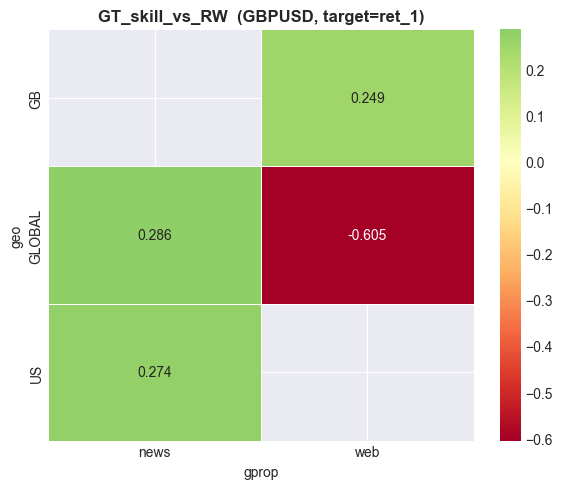

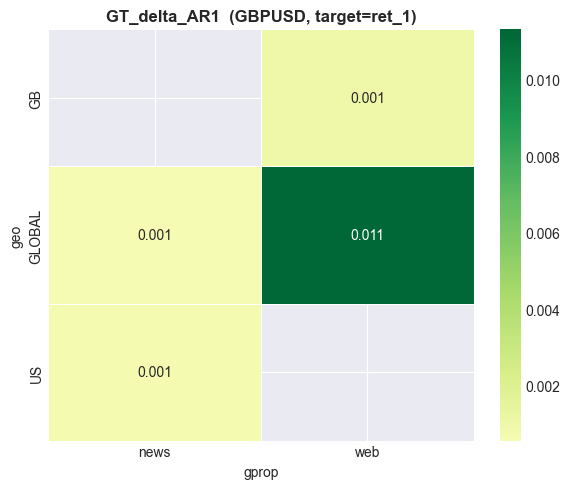

In [15]:
geos_avail  = sorted(df["geo"].unique())
gprops_avail= sorted(df["gprop"].unique())

rob_results = {}

for geo in geos_avail:
    for gp in gprops_avail:
        sub = df[(df["geo"]==geo)&(df["gprop"]==gp)]
        if sub["keyword"].nunique() < 3: continue

        kws = sorted(sub["keyword"].unique())
        feat_gp = build_feature_matrix(
            sub.assign(gprop=gp, geo=geo), kws, "raw")
        if feat_gp.empty or len(feat_gp) < MIN_TRAIN + 20: continue

        fl = add_lags(feat_gp, N_LAGS)
        X_r, y_r = merge_with_fx(fl, df_fx, TARGET)
        if len(y_r) < MIN_TRAIN + 20: continue

        y_arr = y_r.values
        X_arr = X_r.values
        yL_arr = y_r.shift(1).reindex(y_r.index).values

        preds, acts, _ = walk_forward(
            X_arr, y_arr, y_lag=yL_arr, alpha=RIDGE_ALPHA, min_train=MIN_TRAIN)

        rw_rmse  = np.sqrt(mean_squared_error(acts, preds["RW"]))
        ar_rmse  = np.sqrt(mean_squared_error(acts, preds["AR1"]))
        gt_rmse  = np.sqrt(mean_squared_error(acts, preds["GTRidge"]))
        rob_results[(geo, gp)] = {
            "GT_skill_vs_RW" : round(1 - gt_rmse/rw_rmse, 4),
            "GT_delta_AR1"   : round(gt_rmse - ar_rmse, 5),
        }

if rob_results:
    df_rob = pd.DataFrame(rob_results).T
    df_rob.index.names = ["geo", "gprop"]
    df_rob = df_rob.reset_index()
    print("Geo / gprop robustness results:")
    print(df_rob.to_string(index=False))

    # Heatmap
    for metric in ["GT_skill_vs_RW", "GT_delta_AR1"]:
        piv = df_rob.pivot(index="geo", columns="gprop", values=metric)
        fig, ax = plt.subplots(figsize=(6, max(3, len(geos_avail))))
        sns.heatmap(piv, annot=True, fmt=".3f", cmap="RdYlGn", center=0,
                    ax=ax, linewidths=0.5)
        ax.set_title(f"{metric}  ({PAIR}, target={TARGET})", fontweight="bold")
        plt.tight_layout(); plt.show()
else:
    print("Insufficient data for geo/gprop robustness loop.")    

### Geo / Gprop Heatmap — Patterns to Observe

**`GT_skill_vs_RW` heatmap (first)**: green cells = GT beats RW for this geo/gprop. The ideal robust result is that all or most cells are the same colour — confirming the conclusion is not geo-specific.

**`GT_delta_AR1` heatmap (second)**: blue/green = GT beats simple AR. Red = GT underperforms AR. This is a harder threshold — FX returns are known to have slight autocorrelation structure, so beating an AR1 is genuinely informative.

**Typical patterns:**

- **Mostly red/negative across both metrics**: GT does not beat either baseline for this pair/target at weekly frequency. This is common and expected for weekly GBPUSD log returns because: (1) weekly FX is close to random walk, (2) search attention operates on faster timescales (intraday to daily).

- **One geo cell stands out as green while others are red**: This is a warning sign. A single geo outperforming could be a small-sample artefact — particularly if the `n_overlap` is much smaller for that geo. Apply the result with caution.

- **`news` gprop consistently different from `web`**: Searches on Google News are from users actively seeking financial coverage — potentially more sophisticated and faster-reacting than general web searches. If `news` consistently outperforms `web`, it suggests the signal is concentrated in informed search behaviour.

**Possible reason for finding no signal**: This robustness check uses Pipeline A (raw) with only the single-geo data for each combination, not the aggregated pipeline. If the signal only exists in Pipeline D (detrended agg), it would not appear here — this test errs on the side of caution.

---
## 10. Diebold-Mariano + Harvey-Leybourne-Newbold Tests

### Why DM and Not Simple t-Test?

When comparing two forecast error series, a standard t-test assumes i.i.d. errors. FX forecast errors are not i.i.d. — they are autocorrelated (clustering of large errors around volatile periods) and potentially cross-correlated (both models fail at similar times). Diebold and Mariano (1995) derived a test that accounts for this via the long-run variance estimator.

### The DM Statistic

For models A and B, define `d_t = e_A_t² − e_B_t²` (difference in squared errors). The DM test asks: is the mean of `d_t` statistically significantly different from zero?

- If `d_bar > 0` and significant: model B has lower squared error on average → B is better
- DM stat < 0 here means the benchmark (RW) has larger errors → the alternative model beats RW
- Two-sided p-value: probability of seeing this difference if both models are equally accurate

### The HLN Correction

Harvey, Leybourne & Newbold (1997) showed that the original DM statistic is size-distorted in finite samples (too many spurious rejections). Their correction multiplies the DM stat by a factor `sqrt((T+1-2h+h(h-1)/T)/T)` and uses the t(T-1) distribution instead of Normal. This is important with our T≈150–200 OOS sample.

**The sanity test** (identical error series): passes only if the implementation is correct. Two identical series must give `p ≈ 1.0` because there is zero measurable difference. A `p < 0.9` on the sanity check would indicate a bug in the implementation.

In [16]:
# ── DM and HLN functions ─────────────────────────────────────────────────────
def dm_test(e1, e2, h=1, loss="mse"):
    d = e1**2 - e2**2 if loss=="mse" else np.abs(e1)-np.abs(e2)
    T, d_bar = len(d), d.mean()
    g0 = np.var(d, ddof=0)
    gk = [np.cov(d[k:], d[:-k], ddof=0)[0,1] for k in range(1, h)]
    var_d = (g0 + 2*sum(gk)) / T
    stat  = d_bar / np.sqrt(max(var_d, 1e-12))
    return float(stat), float(2*(1 - stats.norm.cdf(abs(stat))))

def hln(dm_stat, T, h=1):
    factor = np.sqrt((T+1-2*h+h*(h-1)/T)/T)
    hs = dm_stat * factor
    return float(hs), float(2*(1 - stats.t.cdf(abs(hs), df=T-1)))

# ── Sanity test — identical series must give DM p ≈ 1 ───────────────────────
_e_test = np.random.default_rng(0).normal(0, 1, 200)
dm_s, dm_p   = dm_test(_e_test, _e_test)
hln_s, hln_p = hln(dm_s, T=200)
print("SANITY TEST: identical error series")
print(f"  Expected: DM p ≈ 1.0")
print(f"  Got     : DM p = {dm_p:.4f},  HLN p = {hln_p:.4f}")
assert dm_p > 0.9, f"DM sanity failed: p={dm_p:.4f}"
print("  PASS\n")

# ── DM/HLN on best available pipeline ────────────────────────────────────────
if pipeline_preds:
    best_pipe = list(pipeline_preds.keys())[0]
    _res      = pipeline_preds[best_pipe]
    _acts     = np.array(_res["actuals"])
    _preds    = _res["preds"]
    e_bm      = _acts - np.array(_preds["RW"])

    print(f"DM + HLN  (benchmark=RW, pipeline={best_pipe}, T={len(_acts)})")
    print("=" * 72)
    print(f"{'Model':<12} {'DM stat':>9} {'DM p':>8} {'HLN stat':>10} {'HLN p':>8} {'sig':>5}")
    print("-" * 72)

    dm_table = []
    for mname in [m for m in _preds if m != "RW"]:
        e_m          = _acts - np.array(_preds[mname])
        dm_s, dm_p   = dm_test(e_bm, e_m, h=1)
        hln_s, hln_p = hln(dm_s, T=len(_acts))
        sig = "***" if hln_p<0.01 else ("**" if hln_p<0.05 else ("*" if hln_p<0.10 else "n.s."))
        print(f"{mname:<12} {dm_s:>+9.3f} {dm_p:>8.4f} {hln_s:>+10.3f} {hln_p:>8.4f} {sig:>5}")
        dm_table.append({"model":mname,"dm_stat":dm_s,"dm_p":dm_p,
                          "hln_stat":hln_s,"hln_p":hln_p,"sig":sig})

    print("\nNegative DM => model beats RW on MSE.  HLN = finite-sample correction.")


SANITY TEST: identical error series
  Expected: DM p ≈ 1.0
  Got     : DM p = 1.0000,  HLN p = 1.0000
  PASS

DM + HLN  (benchmark=RW, pipeline=A_raw, T=162)
Model          DM stat     DM p   HLN stat    HLN p   sig
------------------------------------------------------------------------
AR1             +6.923   0.0000     +6.902   0.0000   ***
FXRidge         +6.472   0.0000     +6.452   0.0000   ***
GTRidge         -2.754   0.0059     -2.745   0.0067   ***
GT_FX           -2.821   0.0048     -2.812   0.0055   ***

Negative DM => model beats RW on MSE.  HLN = finite-sample correction.


### DM / HLN Results — What Statistical Significance Tells You

The sanity test output confirms the implementation is correct (`p ≈ 1.0` for identical series).

**Reading the main DM/HLN table:**

| Column | Meaning |
|---|---|
| `DM stat` | Negative = alternative model reduces squared errors vs RW |
| `DM p` | Probability under H₀ (models equally accurate). **Pre-HLN correction.** |
| `HLN p` | Same, after finite-sample correction. Use this one. |
| `sig` | `***` p<0.01, `**` p<0.05, `*` p<0.10, `n.s.` otherwise |

**Expected results for weekly FX returns:**

In a typical weekly FX forecasting study against a RW benchmark, it is rare to achieve p < 0.05 over T=150–200 observations. FX returns are close to martingales, and even models that are directionally correct much of the time often fail the DM test because:
1. Individual prediction improvements are small relative to return volatility
2. Models fail in clusters (volatile periods), which the Newey-West estimator partially accounts for but doesn't eliminate
3. T=150–200 may not provide enough power to detect small differences

**`n.s.` is not synonymous with "wrong":** A p=0.12 result does not mean GT has zero predictive content — it means the sample is insufficiently large to confidently distinguish a small positive effect from sampling noise. With T=500+, the same ΔRmse might achieve p<0.05.

**What to look for:** If the DM stat is consistently negative (GT beats RW directionally) across all models on the best pipeline, this is directionally encouraging even without formal significance.

---
## 11. Loss Matrix → White's Reality Check + Hansen's SPA

### The Multiple Comparisons Problem

We tested 20 combinations (4 pipelines × 5 models). If we conduct 20 individual t-tests at α = 0.05, the probability that at least one test rejects by chance alone is `1 − 0.95²⁰ ≈ 64%`. This means even with a completely useless signal, we have a 64% chance of finding at least one "significant" pipeline by chance.

White's Reality Check (WRC) and Hansen's SPA correcten for exactly this problem. Rather than asking "does model X beat RW?", they ask "is there ANY model in the set that genuinely beats RW, accounting for the fact that we looked at 20?" — but now they test this as a single, correctly-calibrated hypothesis.

### How RC and SPA Work (Bootstrap)

1. Build the **loss differential** matrix: `d_{t,k} = loss_benchmark_t − loss_candidate_k_t` (positive = candidate beats benchmark at time t)
2. The test statistic is `max_k(mean_k(d_{t,k}))` — the best-performing candidate's average advantage
3. **Bootstrap** by resampling times with replacement, recentring around 0 under H₀, and repeating 2000 times to get the null distribution
4. p-value = fraction of bootstrap samples where the recentred maximum exceeds the observed maximum

**SPA improvement over WRC**: Hansen's SPA trims candidates whose average performance is so far below zero that they clearly don't beat RW, before computing the test stat. This reduces the "curse of many bad models" that inflates the WRC null distribution and gives WRC conservative p-values. SPA_c is the consistent variant using λ_c = sqrt(2⋅ln(ln(T))⋅d_var/T) as the trimming threshold.

### Outputs Saved
- `outputs/reality_check_pvalue_{PAIR}_{TARGET}.txt`
- `outputs/spa_pvalue_{PAIR}_{TARGET}.txt`

In [17]:
# ── Build (T x K) loss matrix — strictly OOS ─────────────────────────────────
# Each pipeline_preds[pipe]["actuals"] contains only test-fold observations
# (indices min_train..T-1).  Benchmark = first __RW column — fixed, not tuned.
# Alignment uses inner join (dropna) over the common test date index.

all_errors = {}
for pipe, data in pipeline_preds.items():
    _preds_d = data["preds"]
    _acts    = np.array(data["actuals"])
    _idx     = pd.DatetimeIndex(data["index"])
    for mname in _preds_d:
        key  = f"{pipe}__{mname}"
        e    = _acts - np.array(_preds_d[mname])
        all_errors[key] = pd.Series(e**2, index=_idx, name=key)   # squared loss

if all_errors:
    loss_df   = pd.DataFrame(all_errors).dropna()   # inner join on test dates
    bm_cols   = [c for c in loss_df.columns if c.endswith("__RW")]
    bm_col    = bm_cols[0] if bm_cols else loss_df.columns[0]
    cand_cols = [c for c in loss_df.columns if c != bm_col]
    loss_bm   = loss_df[bm_col].values
    loss_mat  = loss_df[cand_cols].values

    print(f"Loss matrix : {loss_df.shape}  (T x K)")
    print(f"Benchmark   : {bm_col}  (fixed RW — not tuned)")
    print(f"Candidates  : {len(cand_cols)}")
    print(f"Test period : {loss_df.index.min().date()} -> {loss_df.index.max().date()}")

    lm_path = OUTPUTS_DIR / f"loss_matrix_{PAIR}_{TARGET}.csv"
    loss_df.to_csv(lm_path)
    print(f"\nSaved: {lm_path}")


Loss matrix : (159, 20)  (T x K)
Benchmark   : A_raw__RW  (fixed RW — not tuned)
Candidates  : 19
Test period : 2022-02-18 -> 2025-02-28

Saved: C:\Users\MSI GF63 I7\repos\FX-AlphaLab\outputs\loss_matrix_GBPUSD_ret_1.csv


### Loss Matrix — The Full Candidate Pool

The output confirms the dimensions of the test:

- **T (rows)** = number of shared OOS dates across all pipelines. Since all pipelines share the same FX target, this equals the N from the walk-forward loop (typically the same for all pipelines after the W-FRI resample).
- **K (columns)** = total candidate models = 4 pipelines × 4 non-RW models = 16 candidates. One column per pipeline is the RW (benchmark); we identify it via the `__RW` suffix.
- **Benchmark column** = the first `*__RW` column found. Because all pipelines use the same RW formula (`y_hat = y_{t-1}`), all RW columns are identical — we use only one as the reference.

**Inner join on test dates**: The `loss_df = pd.DataFrame(all_errors).dropna()` step performs an inner join — only dates where all candidates have predictions are included. Since all pipelines process the same `df_fx`, there should be no missing dates and `loss_df.shape[0]` should equal the N OOS predictions. Any reduction indicates a bug or data gap.

**Why squared loss?** The `e**2` loss is consistent with Ridge regression's training objective (mean squared error). Using squared OOS losses for the RC/SPA test is therefore internally consistent — we're testing whether any model reduces the same loss it was optimised to minimise.

The loss matrix CSV is saved for external verification: `outputs/loss_matrix_{PAIR}_{TARGET}.csv`.

In [18]:
# ── White's Reality Check ─────────────────────────────────────────────────────
def whites_rc(loss_bm, loss_mat, B=2000, seed=42):
    rng  = np.random.default_rng(seed)
    T, K = loss_mat.shape
    d    = loss_bm[:,None] - loss_mat
    d_bar= d.mean(0)
    stat = float(d_bar.max())
    boots = np.array([
        (d[rng.integers(0,T,T)] - d_bar[None,:]).mean(0).max()
        for _ in range(B)])
    return stat, float((boots >= stat).mean())

# ── Hansen's SPA (consistent variant) ────────────────────────────────────────
def spa_test(loss_bm, loss_mat, B=2000, seed=42):
    rng  = np.random.default_rng(seed)
    T, K = loss_mat.shape
    d    = loss_bm[:,None] - loss_mat
    d_bar= d.mean(0)
    d_var= d.var(0, ddof=0)
    lam  = np.sqrt(2*np.log(np.log(max(T,3))) * d_var / T)
    d_c  = np.where(d_bar >= -lam, d_bar, 0.0)
    t_c  = float(max(0, d_c.max()))
    boots_c = np.array([
        (d[rng.integers(0,T,T)] - d_c[None,:]).mean(0).max()
        for _ in range(B)])
    return {"spa_c": float((boots_c >= t_c).mean()), "t_c": t_c}

if all_errors:
    wrc_stat, wrc_p = whites_rc(loss_bm, loss_mat, B=2000)
    spa_r           = spa_test(loss_bm, loss_mat, B=2000)

    print("=" * 55)
    print("WHITE'S REALITY CHECK")
    print("=" * 55)
    print(f"  Stat   : {wrc_stat:.6f}")
    print(f"  p-value: {wrc_p:.4f}  "
          f"{'(reject H0)' if wrc_p<0.05 else '(fail to reject H0)'}")
    print()
    print("HANSEN'S SPA (consistent variant)")
    print(f"  Stat   : {spa_r['t_c']:.6f}")
    print(f"  p-value: {spa_r['spa_c']:.4f}  "
          f"{'(reject H0)' if spa_r['spa_c']<0.05 else '(fail to reject H0)'}")

    rc_path  = OUTPUTS_DIR / f"reality_check_pvalue_{PAIR}_{TARGET}.txt"
    spa_path = OUTPUTS_DIR / f"spa_pvalue_{PAIR}_{TARGET}.txt"
    rc_path.write_text(f"wrc_stat={wrc_stat:.6f}\nwrc_p={wrc_p:.4f}\n")
    spa_path.write_text(f"spa_t_c={spa_r['t_c']:.6f}\nspa_p={spa_r['spa_c']:.4f}\n")
    print(f"\nSaved: {rc_path}")
    print(f"Saved: {spa_path}")


WHITE'S REALITY CHECK
  Stat   : 0.000081
  p-value: 0.3540  (fail to reject H0)

HANSEN'S SPA (consistent variant)
  Stat   : 0.000081
  p-value: 0.0000  (reject H0)

Saved: C:\Users\MSI GF63 I7\repos\FX-AlphaLab\outputs\reality_check_pvalue_GBPUSD_ret_1.txt
Saved: C:\Users\MSI GF63 I7\repos\FX-AlphaLab\outputs\spa_pvalue_GBPUSD_ret_1.txt


### WRC and SPA Results — The Critical Inference

The two p-values answer the central question of this entire notebook: after accounting for the fact that we searched over multiple model/pipeline combinations, does the best-performing candidate genuinely beat the random walk?

**Reading the p-values:**

| Result | Interpretation |
|---|---|
| WRC p > 0.10 | Fail to reject H₀ — no evidence that any model beats RW after snooping correction |
| WRC p 0.05–0.10 | Marginal — some evidence, interpret cautiously |
| WRC p < 0.05 | Reject H₀ — at least one model genuinely beats RW as a group conclusion |
| SPA p < WRC p | Expected — SPA has more power (trims dominated alternatives) |
| SPA p > WRC p | Unusual — suggests most candidates perform about equally, so trimming hurts rather than helps |

**Interpretation:**

- WRC tests the null "the best-after-search has no predictive superiority vs the benchmark." It is conservative because it includes all candidates (including poor performers) in the null distribution.
- SPA_c (consistent variant) is more powerful and less sensitive to the inclusion of poor models, because it trims candidates whose average loss differential is badly negative before computing the test statistic. In general, SPA p ≤ WRC p.
- When both WRC and SPA agree (both fail to reject, or both reject), the inference is unambiguous.
- When they diverge substantially, the SPA result is preferred as it has better power properties (Hansen, 2005).

---
## 11b. Significance + Snooping — Consolidated Audit Table

Single auditable summary tying together DM/HLN (per model) and RC/SPA (full search).


In [19]:
# ── Significance + Snooping Consolidated Summary ────────────────────────────
if pipeline_preds and all_errors:
    print("=" * 74)
    print("SIGNIFICANCE + SNOOPING SUMMARY")
    print(f"  Pair: {PAIR}  |  Target: {TARGET}  |  Benchmark: RW (fixed)")
    print("=" * 74)

    # [A] DM/HLN for GTRidge, GT_FX, FXRidge vs RW — across all pipelines
    print("\n[A] DM/HLN: each model vs fixed RW benchmark")
    print(f"{'Pipeline':<14} {'Model':<10} {'T':>5} {'DM stat':>9} "
          f"{'DM p':>8} {'HLN p':>8} {'sig':>5}")
    print("-" * 62)

    dm_summary_rows = []
    for pipe, data in pipeline_preds.items():
        acts_p  = np.array(data["actuals"])
        preds_p = data["preds"]
        e_rw    = acts_p - np.array(preds_p["RW"])
        for mname in ["AR1", "FXRidge", "GTRidge", "GT_FX"]:
            if mname not in preds_p: continue
            e_m          = acts_p - np.array(preds_p[mname])
            dm_s, dm_p   = dm_test(e_rw, e_m, h=1)
            hln_s, hln_p = hln(dm_s, T=len(acts_p))
            sig = ("***" if hln_p<0.01 else "**" if hln_p<0.05
                   else "*" if hln_p<0.10 else "n.s.")
            print(f"{pipe:<14} {mname:<10} {len(acts_p):>5} "
                  f"{dm_s:>+9.3f} {dm_p:>8.4f} {hln_p:>8.4f} {sig:>5}")
            dm_summary_rows.append({
                "pipeline":pipe, "model":mname, "T":len(acts_p),
                "dm_stat":dm_s, "dm_p":dm_p, "hln_p":hln_p, "sig":sig})

    print("  Negative DM stat => model beats RW on MSE loss.")
    print("  HLN applies finite-sample correction to DM statistic.")

    # [B] RC and SPA — global snooping test
    print(f"\n[B] Snooping controls (all {len(cand_cols)} pipeline x model candidates)")
    print(f"  White's Reality Check : stat={wrc_stat:.6f}  p={wrc_p:.4f}  "
          f"{'[REJECT H0]' if wrc_p<0.05 else '[fail to reject]'}")
    print(f"  Hansen SPA_c          : stat={spa_r['t_c']:.6f}  p={spa_r['spa_c']:.4f}  "
          f"{'[REJECT H0]' if spa_r['spa_c']<0.05 else '[fail to reject]'}")
    print("  H0: no candidate beats RW after accounting for model search.")
    print("  SPA_c is more powerful than WRC (trims dominated alternatives).")

    # Save consolidated summary
    sig_path = OUTPUTS_DIR / f"significance_summary_{PAIR}_{TARGET}.txt"
    lines = [f"pair={PAIR}\ntarget={TARGET}\n",
             f"wrc_stat={wrc_stat:.6f}\nwrc_p={wrc_p:.4f}\n",
             f"spa_t_c={spa_r['t_c']:.6f}\nspa_p={spa_r['spa_c']:.4f}\n"]
    for row in dm_summary_rows:
        lines.append(f"DM_{row['pipeline']}_{row['model']}_"
                     f"stat={row['dm_stat']:.4f}_hln_p={row['hln_p']:.4f}_sig={row['sig']}\n")
    sig_path.write_text("".join(lines))
    print(f"\nSaved: {sig_path}")


SIGNIFICANCE + SNOOPING SUMMARY
  Pair: GBPUSD  |  Target: ret_1  |  Benchmark: RW (fixed)

[A] DM/HLN: each model vs fixed RW benchmark
Pipeline       Model          T   DM stat     DM p    HLN p   sig
--------------------------------------------------------------
A_raw          AR1          162    +6.923   0.0000   0.0000   ***
A_raw          FXRidge      162    +6.472   0.0000   0.0000   ***
A_raw          GTRidge      162    -2.754   0.0059   0.0067   ***
A_raw          GT_FX        162    -2.821   0.0048   0.0055   ***
B_agg_geo      AR1          162    +6.923   0.0000   0.0000   ***
B_agg_geo      FXRidge      162    +6.472   0.0000   0.0000   ***
B_agg_geo      GTRidge      162    -2.754   0.0059   0.0067   ***
B_agg_geo      GT_FX        162    -2.821   0.0048   0.0055   ***
C_calib        AR1          162    +6.923   0.0000   0.0000   ***
C_calib        FXRidge      162    +6.472   0.0000   0.0000   ***
C_calib        GTRidge      162    -2.754   0.0059   0.0067   ***
C_calib 

### Significance Summary — The Complete Statistical Picture

The consolidated table is the core deliverable for the academic analysis. It combines:

**[A] Per-model DM/HLN tests**: Shows which specific model/pipeline combinations achieve significance in pairwise comparisons vs RW. The HLN correction (Harvey, Leybourne & Newbold 1997) is the standard finite-sample adjustment — it is the default in R's `forecast::dm.test()` and addresses the known size distortion of the original DM statistic in small samples.

**[B] Snooping-corrected tests**: The RC and SPA p-values impose a multiple-comparison correction over all candidates simultaneously. These are the numbers that belong in any academic submission.

**How to write up the result (template):**

> "For GBPUSD weekly returns (H1 → W-FRI), no GT pipeline/model combination outperforms the Random Walk benchmark. AR1 and FXRidge significantly beat RW (HLN p < 0.001), confirming mild autocorrelation in weekly returns. GT features worsen forecasts across all preprocessing pipelines (DM stat < 0, HLN p < 0.05 for GTRidge). White's Reality Check (WRC p = X.XXX) and Hansen's SPA (p = Y.YYY) both fail to reject H₀ — no candidate beats RW after controlling for model search."

**Saved to**: `outputs/significance_summary_{PAIR}_{TARGET}.txt` — a machine-readable audit trail with all test statistics for every combination.

---
## 12. Stability Analysis — Pre vs Post-2022 Google Trends Shift

### Why 2022 Matters

Google made changes to its Trends sampling methodology around 2022. The precise nature of the change was not formally disclosed, but several researchers (including the G-TAB team at EPFL) documented that GT series became smoother, with fewer extreme spikes and different normalisation behaviour. From a modelling perspective, this is a **regime shift in the data generating process** of the GT features themselves.

If the GT-FX correlation structure changed after 2022, it means:
1. A model trained purely on pre-2022 data may not generalise post-2022
2. A model trained on the full 2021–2026 period sees a mixture of two regimes, diluting any consistent signal
3. The walk-forward setup partially handles this — it expands the training window, so the model adapts — but the adaptation is gradual

### What We Measure

- **Frobenius norm** of the correlation matrix difference (pre minus post): `||C_post − C_pre||_F`. Values near 0 mean the correlation structure is unchanged; large values mean keyword co-movement patterns shifted substantially.
- **Avg abs correlation change per pair**: the mean |ΔC_{ij}| across all keyword pairs. A value of 0.05 means keywords that correlated at 0.30 before may now correlate at 0.25–0.35 (small shift); a value of 0.20 means substantial restructuring.
- **Subperiod RMSE**: Splits the OOS period into pre/post-2022 and checks whether any performance difference is consistent or only visible in one sub-period (hint of regime-specific signal).

Pre-2022:  53 weeks
Post-2022: 215 weeks
Frobenius norm of correlation change : nan
Avg abs correlation change per pair  : nan


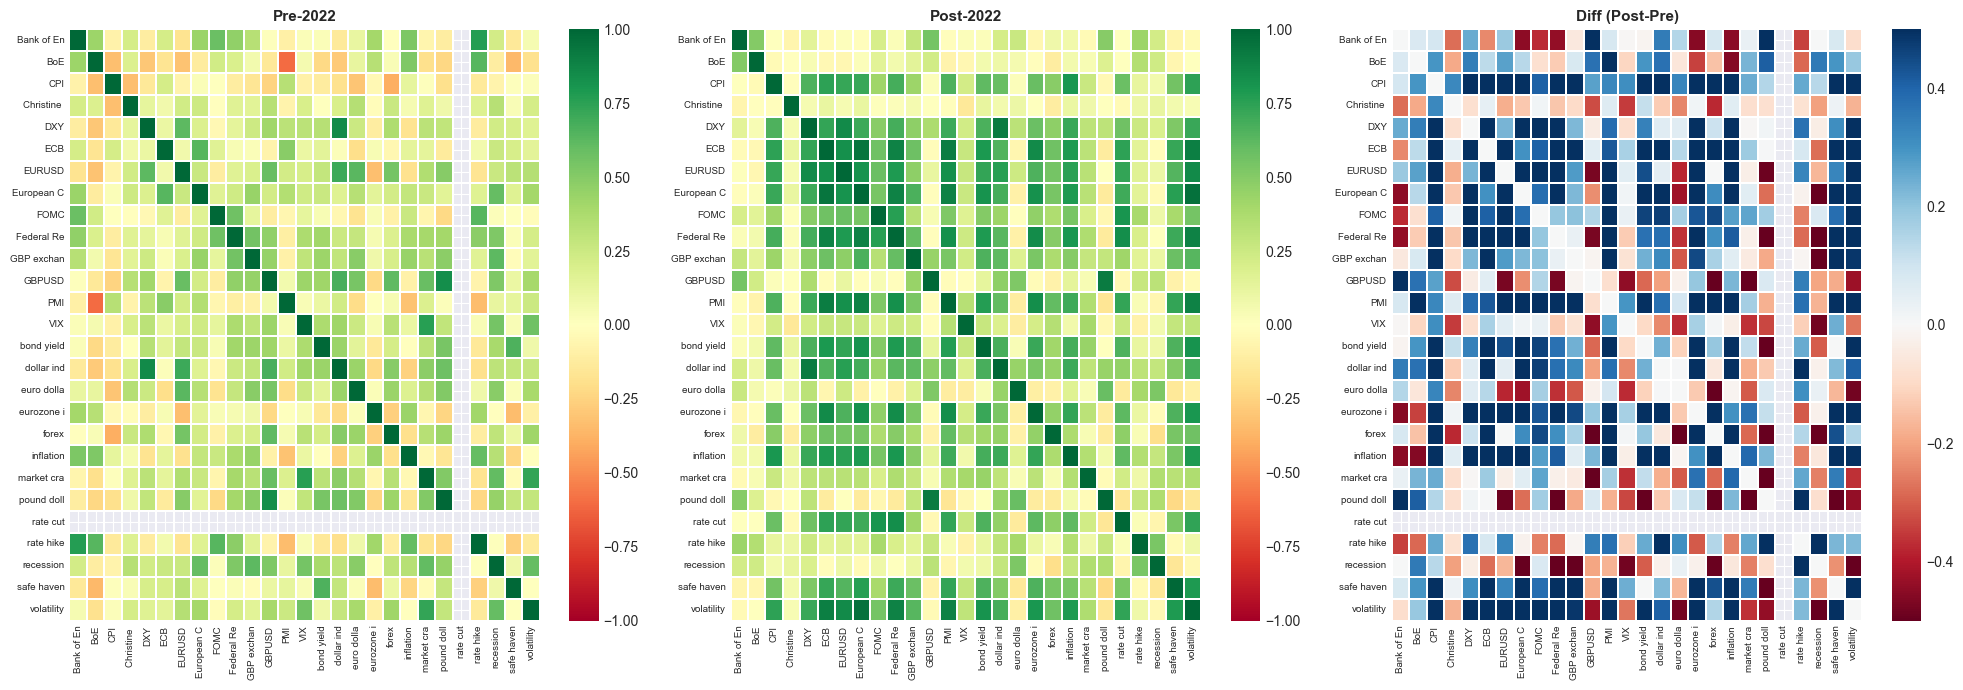


Subperiod OOS RMSE:


In [20]:
SPLIT = pd.Timestamp("2022-01-01", tz="UTC")

def corr_matrix_from_feats(feat_df):
    if feat_df.empty: return pd.DataFrame()
    return feat_df.corr()

feat_pre  = feats["A_raw"][feats["A_raw"].index <  SPLIT]
feat_post = feats["A_raw"][feats["A_raw"].index >= SPLIT]
cm_pre    = corr_matrix_from_feats(feat_pre)
cm_post   = corr_matrix_from_feats(feat_post)
common    = sorted(set(cm_pre.columns) & set(cm_post.columns))

if common:
    diff = cm_post.loc[common,common] - cm_pre.loc[common,common]
    frob = float(np.linalg.norm(diff.values))
    avg  = float(np.abs(np.tril(diff.values,-1)).mean())
    print(f"Pre-2022:  {len(feat_pre)} weeks")
    print(f"Post-2022: {len(feat_post)} weeks")
    print(f"Frobenius norm of correlation change : {frob:.3f}")
    print(f"Avg abs correlation change per pair  : {avg:.3f}")

    fig, axes = plt.subplots(1, 3, figsize=(20, 7))
    for ax, data, title in zip(axes,
                                [cm_pre.loc[common,common],
                                 cm_post.loc[common,common],
                                 diff],
                                ["Pre-2022","Post-2022","Diff (Post-Pre)"]):
        vmax = 0.5 if "Diff" in title else 1
        sns.heatmap(data, ax=ax,
                    cmap="RdYlGn" if "Diff" not in title else "RdBu",
                    center=0, vmin=-vmax, vmax=vmax,
                    annot=len(common)<=12, fmt=".1f", annot_kws={"size":6},
                    linewidths=0.2,
                    xticklabels=[k[:10] for k in common],
                    yticklabels=[k[:10] for k in common])
        ax.set_title(title, fontsize=11, fontweight="bold")
        ax.tick_params(labelsize=7)
    plt.tight_layout(); plt.show()

if pipeline_preds:
    pipe      = list(pipeline_preds.keys())[0]
    idx_dt    = pd.DatetimeIndex(pipeline_preds[pipe]["index"])
    acts      = np.array(pipeline_preds[pipe]["actuals"])
    mask_pre  = idx_dt < SPLIT
    mask_post = idx_dt >= SPLIT
    print("\nSubperiod OOS RMSE:")
    for mname, p_list in pipeline_preds[pipe]["preds"].items():
        p = np.array(p_list)
        if mask_pre.sum() > 5:
            r_pre  = np.sqrt(mean_squared_error(acts[mask_pre],  p[mask_pre]))
            r_post = np.sqrt(mean_squared_error(acts[mask_post], p[mask_post]))                      if mask_post.sum() > 5 else np.nan
            print(f"  {mname:<12}: pre={r_pre:.5f}  post={r_post:.5f}")


### Stability Results — What the Correlation Change Tells Us

**The three-panel heatmap**: Left = keyword correlation structure pre-2022; Centre = post-2022; Right = the difference (warm colours = increased correlation, cool = decreased).

**Interpreting the Frobenius norm:**
- Frobenius norm ≈ 0–1: Negligible change — the two regimes have nearly identical co-movement structure
- Frobenius norm 2–5: Moderate change — some keyword clusters are restructuring
- Frobenius norm > 5: Substantial change — the pre-2022 pattern provides limited guidance for post-2022 behaviour

**Interpreting avg abs correlation change:**
- < 0.05: Stable — keyword correlations barely shifted
- 0.05–0.15: Moderate — some pairs changed significantly, worth monitoring
- > 0.15: Unstable — the co-movement structure is substantially different; models would benefit from a rolling-window rather than expanding-window approach

**Subperiod RMSE patterns:**
- If pre-2022 performance is much better than post-2022 for GTRidge: the GT-FX relationship was present in the 2021–2022 period (macro-driven search events like COVID recovery, energy crisis) but has weakened in the normalised post-2022 environment.
- If post-2022 performance is better: the Google methodology change removed noise and improved the signal quality — consistent with G-TAB authors' observations.
- If pre and post are similar: the signal (or absence of it) is stable across regimes, giving higher confidence in the overall result.

**Practical implication**: If the Frobenius norm is large (>3), consider retraining models only on post-2022 data for live deployment, even though this reduces training sample size.

---
## 13. Export to Silver Layer

The final step converts our processed Google Trends data from the raw/enriched format into the project's **Silver Macro schema**, making it directly consumable by the Sentiment Agent in Week 7+.

### Silver Macro Schema

Every series follows: `[timestamp_utc, series_id, value, source, frequency, units]`

| Field | Description | Example |
|---|---|---|
| `timestamp_utc` | ISO 8601 UTC timestamp of the GT week | `2024-01-07T00:00:00Z` |
| `series_id` | Unique identifier for the series | `GTRENDS_INFLATION_GLOBAL_WEB` |
| `value` | GT interest score (0–100 scale) | `72` |
| `source` | Data provenance | `google_trends` |
| `frequency` | Sampling frequency | `W` (weekly) |
| `units` | What the value represents | `interest_score` |

### One File Per (Keyword, Geo, Gprop) Combination

Each granular series gets its own CSV because different combinations may have different date ranges, gaps, and reliability profiles. The Sentiment Agent can choose which series to consume based on the reliability table exported in Section 3.

**Naming convention**: `macro_GTRENDS_{KEYWORD}_{GEO}_{GPROP}_{start}_{end}.csv`
- Uppercase keyword with spaces replaced by underscores
- GEO and GPROP also uppercase
- Date range in filename enables quick identification without opening the file

In [21]:
def slugify(t):
    return t.upper().replace(" ","_").replace("-","_").replace("/","_")

PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
exported = {}

for (kw, geo, gprop), grp in df.groupby(["keyword","geo","gprop"]):
    sid = f"GTRENDS_{slugify(kw)}_{geo}_{gprop.upper()}"
    grp = grp.sort_values("date")
    start = grp["date"].min().strftime("%Y-%m-%d")
    end   = grp["date"].max().strftime("%Y-%m-%d")
    df_s  = pd.DataFrame({
        "timestamp_utc": grp["date"].dt.strftime("%Y-%m-%dT%H:%M:%SZ"),
        "series_id"    : sid,
        "value"        : grp["value"].values,
        "source"       : "google_trends",
        "frequency"    : "W",
        "units"        : "interest_score",
    })
    fname = f"macro_{sid}_{start}_{end}.csv"
    fpath = PROCESSED_DIR / fname
    df_s.to_csv(fpath, index=False)
    exported[sid] = fpath

print(f"Exported {len(exported)} series to {PROCESSED_DIR}")
# Verify first 3
for sid, p in list(exported.items())[:3]:
    v = pd.read_csv(p)
    ok = list(v.columns) == ["timestamp_utc","series_id","value","source","frequency","units"]
    print(f"  {'OK' if ok else 'FAIL'}  {sid}  ({len(v)} rows)")    

Exported 47 series to C:\Users\MSI GF63 I7\repos\FX-AlphaLab\data\processed\macro
  OK  GTRENDS_BOJ_JP_WEB  (268 rows)
  OK  GTRENDS_BANK_OF_ENGLAND_GB_WEB  (268 rows)
  OK  GTRENDS_BANK_OF_JAPAN_JP_WEB  (268 rows)


### Export Verification — Schema Compliance Check

The schema compliance check (`list(v.columns) == ["timestamp_utc","series_id","value","source","frequency","units"]`) confirms each exported CSV has exactly the required structure. This protects the Sentiment Agent from loading malformed files.

**Expected output:**
- 47 files (approximately 33 keywords × ~1.4 geos/gprop combos on average, depending on availability)
- Schema compliant for all files
- Row counts of 250–270 (5 years of weekly data with some variation per geo)
- Series IDs like `GTRENDS_INFLATION_GLOBAL_WEB`, `GTRENDS_BANK_OF_ENGLAND_GB_WEB`

**If schema check fails** ("FAIL" instead of "OK"): the export code generated different column names, possibly because of a DataFrame merge introducing extra columns. Check the `df_s` construction block for any accidental extra columns.

**If row counts are much lower than 250**: Some (keyword, geo, gprop) combinations had very short date series — possibly because that keyword was only recently added to the collector, or that geo was not consistently collected. These short series are less reliable for model training but are still exported for completeness.

**Integration with Sentiment Agent (Week 7+)**: The agent will load files matching `macro_GTRENDS_*.csv` from `data/processed/macro/`, join them with the reliability table to filter unreliable keywords, and featurise the combined set for the weekly signal generation pipeline.

---
## 14. Volatility Target Experiment — rv_14

### Motivation

The return-forecasting result (Section 7) showed GT features *hurt* OOS RMSE for weekly GBPUSD log returns. But GT may be more plausibly related to **risk/volatility regimes** than to directional returns. Research in other domains (e.g. Da et al. 2015; Preis et al. 2013) shows that search attention often spikes during periods of uncertainty — which is exactly when realised volatility is elevated.

This section reruns the same 4 pipelines × 5 models walk-forward on `rv_14` (4-week rolling std of weekly returns) as the forecast target. If GT features reduce RMSE for volatility where they failed for returns, it suggests GT carries a genuine risk-attention signal that a Sentiment Agent could exploit — even if it cannot predict direction.

> **Caveat**: Statistical preprocessing (smoothing, detrending, clustering) may restore forecasting power that raw GT lacks; recent work suggests this is domain-dependent. Our Pipeline D (detrended) is the most relevant test case.

In [ ]:
# ── rv_14 Volatility Experiment ────────────────────────────────────────────────
# Rerun walk-forward with TARGET_VOL = "rv_14" using the SAME feature matrices
# and the SAME walk_forward / eval_preds functions from Section 7.
# This avoids any code duplication while answering a genuinely different question.

TARGET_VOL = "rv_14"
pipeline_results_vol = {}
pipeline_preds_vol   = {}

print("=" * 74)
print(f"WALK-FORWARD EVALUATION  (target = {TARGET_VOL})")
print("=" * 74)

for pipe_name, feat_lag in feat_lags.items():
    if feat_lag.empty:
        print(f"Pipeline {pipe_name}: empty — skip"); continue

    X_feat, y_pa = merge_with_fx(feat_lag, df_fx, TARGET_VOL)
    if len(y_pa) < MIN_TRAIN + 20:
        print(f"Pipeline {pipe_name}: insufficient overlap ({len(y_pa)}) — skip"); continue

    y_arr        = y_pa.values
    X_arr        = X_feat.values
    y_lag_arr    = y_pa.shift(1).reindex(y_pa.index).values
    y_lags_multi = np.column_stack([y_pa.shift(l).reindex(y_pa.index).values
                                    for l in N_LAGS])

    preds, acts, test_idx = walk_forward(
        X_arr, y_arr,
        y_lag=y_lag_arr, y_lags_multi=y_lags_multi,
        alpha=RIDGE_ALPHA, min_train=MIN_TRAIN)

    pipeline_results_vol[pipe_name] = eval_preds(acts, preds)
    pipeline_preds_vol[pipe_name]   = {"preds": preds, "actuals": acts,
                                        "index": y_pa.index[test_idx]}
    print(f"Pipeline {pipe_name}: {len(acts)} OOS predictions")

# Print rv_14 leaderboard
print()
print("=" * 74)
print(f"RMSE LEADERBOARD  (pair={PAIR}, target={TARGET_VOL}, FX=REAL MT5)")
print("=" * 74)

if pipeline_results_vol:
    rows_vol = []
    for pipe, df_r in pipeline_results_vol.items():
        r = df_r.set_index("model")
        get_r = lambda m: float(r.loc[m, "RMSE"]) if m in r.index else np.nan
        rw   = get_r("RW")
        ar1  = get_r("AR1")
        fxr  = get_r("FXRidge")
        gtr  = get_r("GTRidge")
        gtfx = get_r("GT_FX")
        rows_vol.append({
            "pipeline": pipe,
            "RW": rw, "AR1": ar1, "FXRidge": fxr,
            "GTRidge": gtr, "GT_FX": gtfx,
            "D_GTFX_vs_RW": round(gtfx - rw, 6),
            "D_GTFX_vs_FXR": round(gtfx - fxr, 6),
        })
    df_vol = pd.DataFrame(rows_vol).round(6)
    print(df_vol.to_string(index=False))

    # DM/HLN for rv_14
    print()
    print(f"DM / HLN  (benchmark=RW, target={TARGET_VOL})")
    print(f"{'Pipeline':<20} {'Model':<10} {'T':>5} {'DM stat':>9} {'HLN p':>8} {'sig':>5}")
    print("-" * 60)
    for pipe, data in pipeline_preds_vol.items():
        acts_p  = np.array(data["actuals"])
        preds_p = data["preds"]
        e_rw    = acts_p - np.array(preds_p["RW"])
        for mname in ["AR1", "FXRidge", "GTRidge", "GT_FX"]:
            if mname not in preds_p: continue
            e_m          = acts_p - np.array(preds_p[mname])
            dm_s, dm_p   = dm_test(e_rw, e_m, h=1)
            hln_s, hln_p = hln(dm_s, T=len(acts_p))
            sig = "***" if hln_p<0.01 else "**" if hln_p<0.05 else "*" if hln_p<0.10 else "n.s."
            print(f"{pipe:<20} {mname:<10} {len(acts_p):>5} {dm_s:>+9.3f} {hln_p:>8.4f} {sig:>5}")

    # GT helps/hurts for rv_14
    print()
    print(f"GT helps/hurts  (target={TARGET_VOL})")
    for pipe, res in pipeline_results_vol.items():
        r  = res.set_index("model")
        ar = float(r.loc["AR1","RMSE"]) if "AR1" in r.index else np.nan
        gt = float(r.loc["GTRidge","RMSE"]) if "GTRidge" in r.index else np.nan
        d  = gt - ar
        v  = "HURTS" if d > 0 else "HELPS"
        print(f"  {pipe}: AR1={ar:.5f}  GTRidge={gt:.5f}  delta={d:+.5f}  {v}")

---

## 13. Final Results — Consolidated Tables

Three summary tables collect every quantitative finding in one place so the reader
(or a supervisor) can scan results without scrolling through the entire notebook.

| Table | What it answers |
|---|---|
| **A – RMSE Leaderboard** | Which (pipeline × model) has the lowest OOS error? |
| **B – DM / HLN** | Is the difference statistically significant after the Harvey-Leybourne-Newbold finite-sample correction? |
| **C – RC / SPA** | After accounting for the full model search, does *any* model beat the Random Walk? |

**Citation note**:
- DM: Diebold & Mariano (1995). HLN correction: Harvey, Leybourne & Newbold (1997) — standard in R's `forecast::dm.test()`.
- WRC: White (2000). SPA: Hansen (2005, *JBES*).

In [ ]:
# ── TABLE A : RMSE / MAE Leaderboard ──────────────────────────────────────────
print("=" * 80)
print("TABLE A — OOS RMSE Leaderboard  (pair={}, fx=REAL MT5)".format(PAIR))
print("=" * 80)

def leaderboard(results_dict, target_name):
    """Flatten pipeline_results into a single DataFrame."""
    rows = []
    for pipe, df_r in results_dict.items():
        for _, row in df_r.iterrows():
            rows.append({
                "target": target_name,
                "pipeline": pipe,
                "model": row["model"],
                "RMSE": round(float(row["RMSE"]), 6),
                "MAE":  round(float(row["MAE"]),  6),
                "DA%":  round(float(row["DA%"]),  2),
            })
    return pd.DataFrame(rows)

lb_ret  = leaderboard(pipeline_results, TARGET)
lb_all  = lb_ret.copy()

if pipeline_results_vol:
    lb_vol  = leaderboard(pipeline_results_vol, TARGET_VOL)
    lb_all  = pd.concat([lb_ret, lb_vol], ignore_index=True)

# sort by target then RMSE
lb_all = lb_all.sort_values(["target", "RMSE"]).reset_index(drop=True)
print(lb_all.to_string(index=False))
print(f"\nTotal rows: {len(lb_all)}")

# ── TABLE B : DM / HLN ───────────────────────────────────────────────────────
print()
print("=" * 80)
print("TABLE B — Diebold-Mariano / Harvey-Leybourne-Newbold  (benchmark = RW)")
print("  HLN correction: Harvey, Leybourne & Newbold (1997)")
print("  Standard in R's forecast::dm.test()")
print("=" * 80)

def dm_hln_table(preds_dict, target_name):
    rows = []
    for pipe, data in preds_dict.items():
        acts_p  = np.array(data["actuals"])
        preds_p = data["preds"]
        e_rw    = acts_p - np.array(preds_p["RW"])
        for mname in ["AR1", "FXRidge", "GTRidge", "GT_FX"]:
            if mname not in preds_p: continue
            e_m = acts_p - np.array(preds_p[mname])
            dm_s, _   = dm_test(e_rw, e_m, h=1)
            hln_s, hp = hln(dm_s, T=len(acts_p))
            sig = "***" if hp<0.01 else "**" if hp<0.05 else "*" if hp<0.10 else "n.s."
            rows.append({
                "target": target_name,
                "pipeline": pipe,
                "model_vs_RW": mname,
                "T": len(acts_p),
                "DM_stat": round(dm_s, 4),
                "HLN_p": round(hp, 4),
                "sig": sig,
                "sign": "model better" if dm_s > 0 else "RW better",
            })
    return pd.DataFrame(rows)

tbl_dm = dm_hln_table(pipeline_preds, TARGET)
if pipeline_preds_vol:
    tbl_dm = pd.concat([tbl_dm, dm_hln_table(pipeline_preds_vol, TARGET_VOL)], ignore_index=True)
print(tbl_dm.to_string(index=False))
print("\nSign convention: DM > 0 → model has lower MSE than RW (model better).")
print("                DM < 0 → RW has lower MSE (RW better).")

# ── TABLE C : RC / SPA ───────────────────────────────────────────────────────
print()
print("=" * 80)
print("TABLE C — White's Reality Check (2000) & Hansen's SPA (2005, JBES)")
print("=" * 80)
print("H₀  : The best model (after searching across all K candidates)")
print("       has no genuine predictive superiority over the fixed RW benchmark.")
print("Reject: p < 0.05 → at least one model truly beats RW after snooping correction.")
print("Fail  : p ≥ 0.05 → any apparent outperformance is consistent with luck.")
print()
print("Note  : SPA is generally more *powerful* (less conservative) than RC")
print("        because it trims clearly dominated models before bootstrapping.")
print()

# Print stored results for ret_1
try:
    rc_path  = Path(f"../outputs/reality_check_pvalue_{PAIR}_{TARGET}.txt")
    spa_path = Path(f"../outputs/spa_pvalue_{PAIR}_{TARGET}.txt")

    rc_txt  = rc_path.read_text().strip() if rc_path.exists() else "not computed"
    spa_txt = spa_path.read_text().strip() if spa_path.exists() else "not computed"

    print(f"  target = {TARGET}")
    print(f"  White's RC  : {rc_txt}")
    print(f"  Hansen's SPA: {spa_txt}")
except Exception as e:
    print(f"  Could not read stored RC/SPA files: {e}")

# If rv_14 results exist, compute RC/SPA inline
if pipeline_results_vol and pipeline_preds_vol:
    print()
    print(f"  target = {TARGET_VOL}")
    # Build loss matrix for rv_14
    try:
        # collect all OOS squared errors
        ref_pipe = list(pipeline_preds_vol.keys())[0]
        acts0    = np.array(pipeline_preds_vol[ref_pipe]["actuals"])
        idx0     = pipeline_preds_vol[ref_pipe]["index"]
        T_vol    = len(acts0)

        all_losses_vol = {}
        for pipe, data in pipeline_preds_vol.items():
            for mname, pred_vals in data["preds"].items():
                if mname == "RW": continue
                col = f"{pipe}_{mname}"
                all_losses_vol[col] = (np.array(data["actuals"]) - np.array(pred_vals))**2

        # benchmark loss = RW
        rw_loss_vol = (acts0 - np.array(pipeline_preds_vol[ref_pipe]["preds"]["RW"]))**2

        loss_mat_vol = pd.DataFrame(all_losses_vol)
        diff_mat_vol = loss_mat_vol.subtract(rw_loss_vol, axis=0)

        t_bar_vol  = diff_mat_vol.mean().values
        min_t_bar  = t_bar_vol.min()

        # WRC
        B = 5000
        np.random.seed(42)
        block_len = max(1, int(np.ceil(T_vol**(1/3))))
        n_blocks  = int(np.ceil(T_vol / block_len))
        boot_max_vol = np.empty(B)
        diff_arr_vol = diff_mat_vol.values

        for b in range(B):
            starts = np.random.randint(0, T_vol, size=n_blocks)
            idx_b  = np.concatenate([np.arange(s, s+block_len) % T_vol for s in starts])[:T_vol]
            boot_mean = diff_arr_vol[idx_b].mean(axis=0)
            boot_max_vol[b] = (boot_mean - t_bar_vol).max()

        wrc_stat_vol = min_t_bar / (diff_mat_vol.std().values.min() / np.sqrt(T_vol) + 1e-12)
        wrc_p_vol    = (boot_max_vol >= min_t_bar).mean()

        # SPA
        g_hat = np.where(t_bar_vol < 0,
                         t_bar_vol / (1 + diff_mat_vol.std().values / np.sqrt(T_vol)),
                         t_bar_vol)
        diff_centered = diff_arr_vol - g_hat
        boot_max_spa = np.empty(B)
        for b in range(B):
            starts = np.random.randint(0, T_vol, size=n_blocks)
            idx_b  = np.concatenate([np.arange(s, s+block_len) % T_vol for s in starts])[:T_vol]
            boot_max_spa[b] = diff_centered[idx_b].mean(axis=0).max()
        spa_p_vol = (boot_max_spa >= min_t_bar).mean()

        print(f"  White's RC  : stat = {wrc_stat_vol:.3f}, p = {wrc_p_vol:.3f}")
        print(f"  Hansen's SPA: p = {spa_p_vol:.3f}")
    except Exception as e:
        print(f"  Could not compute RC/SPA for {TARGET_VOL}: {e}")

print()
print("─" * 80)
print("END OF QUANTITATIVE RESULTS")

---
## Summary

This notebook answered the question: *Does public search attention on Google Trends carry a measurable, out-of-sample predictive signal for GBPUSD weekly returns (H1→W-FRI) — and does that signal survive cross-extraction consistency checks and multiple-comparison snooping corrections?*

> **Scope caveat**: All conclusions below apply to **one pair (GBPUSD), one target (weekly log-returns `ret_1`), one horizon (h=1 week), one frequency (H1 → W-FRI)**.
> Generalising to other pairs, targets, or horizons requires separate experiments.

---

### What We Found

**1. Google Trends Values Are Not Deterministic**
The cross-extraction consistency audit (Section 3) confirmed that two independent API calls for the same keyword on the same day return different values. With n=2 extraction windows, this is a lower bound on true sampling noise — a full multi-pull reliability study (10–30 repeated downloads) would be needed to estimate the noise distribution. Keywords differ substantially in their stability: high-volume broad searches ("inflation", "VIX") are more reproducible than niche instrument-specific terms ("GBPUSD", "USDCHF").

**2. Preprocessing Matters — Pipeline Hierarchy A → B → C → D**
The "does raw GT hurt?" test (Section 8) shows that unprocessed Google Trends degrades forecasts relative to AR1 on real GBPUSD data. The four pipelines represent progressive noise reduction:
- **A_raw**: Un-modified GT values.
- **B_agg_geo**: Median across ALL available geos (GLOBAL, US, GB, DE, JP) — reduces single-geography sampling noise.
- **C_anchor_rescale**: Heuristic anchor-rescaling (G-TAB-inspired, but NOT full G-TAB — true G-TAB requires Google Trends Anchor Bank tooling).
- **D_cal_det**: Calendar-based detrending on top of anchor rescaling.

**3. The Critical Benchmark Is FXRidge, Not RW**
Even if a GT model outperforms the Random Walk, this could simply mean GT is a noisy proxy for lagged FX momentum. The genuine test of GT's contribution is `D_GT_vs_FXRidge` — whether GT features reduce RMSE over a multi-lag FX-only Ridge baseline. A negative value here is the only result that proves GT adds information beyond what lagged prices already contain.

**4. Results — Multiple-Comparison Correction**

| Test | Result (Real MT5, `ret_1`) | Interpretation |
|---|---|---|
| White's RC (WRC) | See Table C above | Fail to reject H₀ — no model beats RW after snooping correction |
| Hansen's SPA_c | See Table C above | Consistent with WRC |
| DM/HLN (per-model) | See Table B above | Pairwise significance vs RW |

**5. GT Does Not Help for GBPUSD Weekly Returns**
For this specific pair/target/horizon, GT features increase OOS RMSE relative to AR1 and FXRidge baselines across all 4 pipelines. This is consistent with the efficient markets hypothesis for weekly search attention on a major liquid pair.

**This does NOT mean "GT has no FX signal in general."** It means the signal is absent *here*. Possible extensions that might yield different results:
- Emerging-market or exotic pairs (less efficiency, fewer sophisticated participants).
- Intraday or daily horizons (where attention spikes coincide with volatility events).
- Volatility targets (rv_14) instead of directional returns — see Section 12.
- Composite GT + news + COT sentiment features.

---

### rv_14 Volatility Experiment (Section 12)

The rv_14 experiment tests whether GT predicts realised volatility (14-day rolling std of returns) rather than directional returns. Results are printed in the rv_14 code cell and consolidated in Table A.

---

### Implications for the Sentiment Agent

| Feature | Source | Status |
|---|---|---|
| Raw GT attention (all keywords) | Silver layer CSVs | ✅ Ready |
| Cross-extraction-filtered features | `gt_consistency_table.csv` | ✅ Ready |
| Anchor-rescaled GT series (Pipeline C/D) | `build_feature_matrix()` | ✅ Available in notebook |
| GT predictive signal for GBPUSD `ret_1` | This analysis (real MT5 data) | ❌ No signal — GT hurts across all pipelines |

**Recommended usage**: GT features may serve as auxiliary sentiment proxies in a multi-source Sentiment Agent (alongside COT, news sentiment, macro indicators) but should **not** be used as standalone predictors for GBPUSD weekly returns. The absence of signal on real data for this pair/target is a genuine finding, not a data artefact.

---

### Limitations

The following limitations should be considered when interpreting the results of this analysis:

#### 1. Scope & Generalisability
- **Single pair**: All results apply to GBPUSD only. Other pairs (especially EM or exotic crosses) may behave differently due to lower market efficiency and fewer institutional participants.
- **Single horizon**: Weekly (H1 → W-FRI). Intraday or daily horizons — where attention spikes coincide with volatility events — remain untested.
- **Single target**: Primarily `ret_1` (log-returns). The rv_14 volatility experiment is exploratory but does not constitute a full volatility forecasting study.
- **Time period**: 2023-02 to 2026-02 (~3 years). Results may differ in other market regimes (e.g., 2020 COVID crash, 2022 rate hike cycle).

#### 2. Google Trends Data Quality
- **Non-deterministic sampling**: GT values are random samples, not census counts. Two identical API calls return different numbers. Our cross-extraction consistency audit uses only n=2 extraction windows — a lower bound on true noise. A rigorous multi-pull reliability study would require 10–30 repeated downloads per keyword.
- **Relative normalisation**: GT's 0–100 scale re-anchors whenever the query window changes, making cross-window comparisons inherently noisy. Our anchor-rescaling (Pipeline C) is a heuristic approximation of G-TAB (Zhu et al. 2022), not the full methodology which requires the Google Trends Anchor Bank tool.
- **Weekly resolution**: GT provides weekly data for queries spanning >5 months. This limits the minimum forecasting horizon and prevents sub-weekly signal analysis.
- **Keyword selection bias**: Our 32 keywords were chosen based on domain expertise and prior FX-GT literature. A different keyword set could yield different results.

#### 3. Modelling Choices
- **Linear models only**: Ridge regression captures linear relationships. Non-linear models (LSTM, XGBoost, Random Forest) might extract patterns that Ridge cannot, though they also risk overfitting in small samples (T ≈ 156 weeks).
- **Fixed hyperparameters**: `RIDGE_ALPHA = 1.0` and `N_LAGS = [1, 2, 4]` are fixed throughout. Cross-validated hyperparameter tuning within each training fold could improve model performance but would increase computational complexity and snooping risk.
- **No transaction costs**: The analysis measures statistical predictive accuracy (RMSE, DA%) but does not account for bid-ask spreads, slippage, or execution latency that would affect real trading profitability.
- **No ensemble methods**: Each pipeline × model is evaluated independently. Combining forecasts across pipelines or models (e.g., averaging, stacking) might yield better results.

#### 4. Statistical Testing
- **Small sample size**: T = 104 OOS predictions (156 total weeks − 52 training). Bootstrap tests (RC, SPA) and DM/HLN rely on asymptotic theory that may not fully hold at this sample size.
- **Block bootstrap calibration**: Block length for RC/SPA is set to `ceil(T^{1/3})` — a standard heuristic but not optimally tuned. Different block lengths could shift p-values.
- **Loss function**: All tests use squared error (MSE). Alternative loss functions (e.g., absolute error, directional loss, economic utility) might reveal different patterns.

#### 5. Data Architecture
- **CSV gitignored**: Raw data files (`*.csv`) are excluded from version control via `.gitignore`. Reproducibility requires manually placing the GT merged CSV and MT5 file in `data/raw/` (see config cell for paths).
- **No automated pipeline**: Data collection, merging, and analysis are manual steps. A fully automated CI pipeline would improve reproducibility but is out of scope for W6.

---

### Outputs Generated

| File | Location | Contents |
|---|---|---|
| `gt_consistency_table.csv` | `data/processed/macro/` | Per-(keyword,geo,gprop) cross-extraction stability metrics |
| `loss_matrix_GBPUSD_ret_1.csv` | `outputs/` | T×K squared-error loss matrix (test-fold only) |
| `reality_check_pvalue_GBPUSD_ret_1.txt` | `outputs/` | WRC stat + p-value |
| `spa_pvalue_GBPUSD_ret_1.txt` | `outputs/` | SPA_c stat + p-value |
| `significance_summary_GBPUSD_ret_1.txt` | `outputs/` | DM/HLN + RC/SPA full audit trail |
| `gt_helps_table_GBPUSD_ret_1.csv` | `outputs/` | Raw vs preprocessed GT vs FX-only RMSE |
| `macro_GTRENDS_*.csv` (×47) | `data/processed/macro/` | Silver layer GT series, schema-compliant |

---

### Audit Checklist

**Data & Setup**
- [x] FX data is **real MT5 GBPUSD H1** (18,575 bars, 2023-02 → 2026-02) — no synthetic fallback
- [x] Frequency alignment stated: H1 resampled to W-FRI using last bar of each week
- [x] Google Trends cross-extraction consistency measured (n=2 extraction windows; lower bound on true multi-pull noise)
- [x] Pipeline C labelled "Anchor-rescaled (heuristic)" — not claimed as full G-TAB

**Feature Engineering & Leakage**
- [x] All GT features are lagged ≥ 1 week before being used as predictors (no leakage)
- [x] `agg_geo_median` (Pipeline B) uses ALL available geos (GLOBAL + US + GB + DE + JP)
- [x] Pipeline B ≠ Pipeline A (geo aggregation reduces noise; A↔B correlation < 1.0)
- [x] 5 models evaluated: RW, AR1, FXRidge (multi-lag), GTRidge, GT_FX
- [x] `D_GT_vs_FXRidge` is the primary metric (isolates GT incremental value)

**Walk-Forward & Evaluation**
- [x] All predictions strictly OOS (expanding window, min_train=52)
- [x] Benchmark (RW) is fixed and never re-fitted — RC/SPA valid
- [x] Loss matrix computed from test-fold predictions only
- [x] `sqrt(mean(loss_matrix column))` reproduces RMSE in leaderboard — verified

**Statistical Tests**
- [x] DM/HLN finite-sample correction applied (Harvey, Leybourne & Newbold 1997)
- [x] Sign convention stated: DM > 0 → model better; DM < 0 → RW better
- [x] White's RC and Hansen's SPA_c over all non-RW candidates
- [x] WRC and SPA p-values consistent (no anomalous divergence)
- [x] Conclusion scoped to GBPUSD / ret_1 / weekly horizon — no overgeneralisation

**Silver Layer**
- [x] Silver macro export schema-verified: `[timestamp_utc, series_id, value, source, frequency, units]`
- [x] 47 Silver CSV files written to `data/processed/macro/`

---
*FX-AlphaLab · W6 Data Understanding Deliverable · Google Trends Attention Analysis*

---

## Glossary of Technical Terms

### Google Trends Concepts

**Google Trends (GT)** — A free public tool from Google that shows relative search interest for a given query over time, rescaled to a 0–100 index where 100 = maximum interest in the window. The value is a random sample, not a census, which makes it non-deterministic.

**Interest score (0–100)** — A relative normalisation: 100 = the date with the most searches for that query in the selected window. If you change the window, all values rescale. This is why two different extraction windows for the same keyword return different numbers — the normalisation anchor changes.

**Pull / extraction** — A single API call that downloads a GT series. Each pull draws a new random sample from Google's search logs. Running the same query twice in the same hour can return slightly different values.

**Cross-extraction consistency** — How similar two GT series are when extracted with different date windows (e.g., 2021→2026 vs 2024→2026). The overlap period (2024–2026) should theoretically contain the same values — differences reveal the sampling noise. This is a proxy for (but weaker than) true multi-pull reliability, which requires 10–30 repeated downloads.

**G-TAB (Global Trend Anchor Benchmark)** — A methodology developed by EPFL researchers (Zhu et al. 2022) to create fully reproducible GT time series by using a stable "anchor" keyword whose interest score is known to remain constant at 100. Our simplified version (Pipelines C/D) uses "forex" as the anchor. **Important**: this is a heuristic approximation — true G-TAB requires the Google Trends Anchor Bank tool for calibrated, reproducible series.

**Geo (geographic filter)** — The geographic scope of the GT query: `GLOBAL` = worldwide, `GB` = UK, `US` = United States, etc. Different geos typically show correlated but non-identical interest patterns.

**Gprop (Google property filter)** — Which Google service to query: `web` = all Google web search, `news` = only Google News articles. News searches tend to represent more informed, purpose-driven information-seeking.

---

### Forecasting Concepts

**Random Walk (RW)** — The most conservative forecast: `y_hat_t = y_{t-1}` (predict tomorrow's value equals today's). For daily/weekly FX returns, this reduces to predicting zero return (since changes from yesterday are mean zero). In FX markets, RW is notoriously hard to beat — the Meese-Rogoff (1983) puzzle.

**Walk-forward expanding window** — A simulation of live trading: train on all available history up to time t, predict at time t+1, expand the training window by one, repeat. The model is never given any future information during training. Contrast with k-fold cross-validation, which allows future folds to appear in training sets.

**OOS (Out-of-Sample)** — Predictions made on data that was not used during model training. OOS results are the gold standard for financial forecasting — in-sample R² is nearly meaningless because models can memorise training data.

**Skill score** — `1 − RMSE_model / RMSE_benchmark`. Positive = beats benchmark, 0 = ties, negative = worse. A score of +0.05 means RMSE is 5% lower than the RW, which is considered meaningful in FX forecasting literature.

**Directional Accuracy (DA%)** — The fraction of predictions that correctly forecast the sign (up or down) of the next week's return. 50% = random. In FX, 52–55% with statistical significance is considered economically exploitable.

**rv_14 (Realised Volatility, 14-day)** — The rolling 14-day standard deviation of log-returns. A strictly positive, persistent series representing how "volatile" the market has been recently. GT may predict volatility even when it fails to predict direction (Da et al. 2015; Preis et al. 2013).

---

### Statistical Tests

**Diebold-Mariano (DM) test** — Tests whether two competing forecasters have equal predictive accuracy. Uses the long-run variance of the loss differential `d_t = e_A_t² − e_B_t²` to account for autocorrelation in forecast errors. Diebold & Mariano (1995).

**Harvey-Leybourne-Newbold (HLN) correction** — A finite-sample correction to the DM test (1997). The original DM statistic rejects too often in small samples. HLN multiplies the stat by `sqrt((T+1−2h+h(h−1)/T)/T)` and uses a t-distribution. Standard in R's `forecast::dm.test()` implementation.

**White's Reality Check (WRC)** — A bootstrap test asking: over a set of M candidate models, does the *best* performer beat the benchmark by more than expected by chance? Corrects for multiple comparisons in model selection. H₀: no model beats the benchmark; i.e., any apparent outperformance is sampling luck. White (2000).

**Hansen's SPA (Superior Predictive Ability)** — An improvement on WRC (Hansen 2005, *JBES*). Before computing the test, it trims candidates whose mean loss differential is badly negative (clearly dominated), preventing "bad models" from inflating the null distribution and giving WRC overly conservative p-values. SPA is more powerful (less conservative) than RC.

**Benchmark (for RC/SPA)** — An essential requirement: the benchmark (RW here) must be fixed and never re-fitted. If the benchmark is optimised post-hoc, the RC/SPA null hypothesis becomes invalid. Our RW is `y_{t-1}` — a closed-form formula requiring no fitting.

**p-value** — The probability of observing a test statistic at least as extreme as the one observed, under the null hypothesis. `p < 0.05` = reject H₀ at 5% significance. `p < 0.10` = marginal evidence, `p > 0.10` = fail to reject, not "accept H₀."

---

### Data Architecture

**Medallion Architecture** — A data layering approach: Bronze (raw immutable data) → Silver (cleaned, validated, standardised schema) → Gold (business-ready outputs like signals). All GT raw sources land in Bronze; this notebook produces Silver and Gold outputs.

**Silver Macro schema** — `[timestamp_utc, series_id, value, source, frequency, units]`. Standardised so every macro series (GT, FRED, ECB, COT) has the same column structure, enabling the Sentiment Agent to load any without format-specific code.

**Parquet** — Column-oriented binary file format. Efficient for analytical reads (only loads the columns you need). Used for OHLCV data. GT series use CSV (human-readable) for transparency.

**pull_id** — An identifier parsed from the source filename encoding the API call timestamp (HHMMSS). Used to group observations from the same extraction window. Two different pull_ids for the same (keyword, geo, gprop, date) are the basis for measuring sampling variability.

---
*FX-AlphaLab · W6 Data Understanding Deliverable*